# Load and clean gnps spectra

The gnps spectra are downloaded on 15-12-2021 (20:00 CET) from https://gnps-external.ucsd.edu/gnpslibrary/ALL_GNPS.mgf

The final file created in this notebook, that is used by other notebooks is named: ALL_GNPS_15_12_2021_inchikeys_from_pubchem.pickle 
In this version, the metadata is cleaned, peaks are normalized and cleaned and missing inchikeys were added by using pubchem. 

Other in between files are:
ALL_GNPS_15_12_2021.mgf Containing the raw spectra of GNPS
ALL_GNPS_15_12_2021_raw_spectra.pickle Contains the raw spectra, in pickled matchms spectra.
ALL_GNPS_15_12_2021_cleaned_metadata.pickle Contains spectra with filtered metadata. No spectra or peaks have been removed.
ALL_GNPS_15_12_2021_removed_peaks.pickle In this version peak and spectra were removed that do not fit within certain criteria (see below).

The next step in data preparation is `notebook 2_split_data.ipynb`

In [1]:
import os
import pickle
from tqdm.notebook import tqdm
from matchms.importing import load_from_mgf

notebook_rerun = True  # Set to True if you want to rerun the notebook

In [2]:
path_data = "C:\\HSD\\OneDrive - Hochschule Düsseldorf\\Data\\ms2query"
path_to_gnps_spectra = os.path.join(path_data, "ALL_GNPS_15_12_2021.mgf")
assert os.path.isfile(path_to_gnps_spectra), \
    "File not found."

In [14]:
if not notebook_rerun:
    gnps_spectra = list(load_from_mgf(path_to_gnps_spectra))
    print(f"Number of spectra in imported data: {len(gnps_spectra)}.")

Number of spectra in imported data: 480947.


Dump spectra in pickle file for quicker loading

In [15]:
if not notebook_rerun:
    pickle.dump(gnps_spectra,
                open(os.path.join(path_data, "ALL_GNPS_15_12_2021_raw_spectra.pickle"), "wb"))

In [4]:
if notebook_rerun:
    outfile = os.path.join(path_data, "ALL_GNPS_15_12_2021_raw_spectra.pickle")
    with open(outfile, 'rb') as file:
        gnps_spectra = pickle.load(file)

In [3]:
def count_annotations(spectra):
    """Function to keep track of the amount of annotated spectra."""
    inchi_lst = []
    smiles_lst = []
    inchikey_lst = []
    nr_of_spectra_with_less_than_3_peaks = 0
    nr_of_spectra_with_more_than_500_peaks = 0

    for i, spec in enumerate(spectra):
        inchi_lst.append(spec.get("inchi"))
        smiles_lst.append(spec.get("smiles"))
        inchikey = spec.get("inchikey")
        if inchikey is None:
            inchikey = spec.get("inchikey_inchi")
        inchikey_lst.append(inchikey)
        if len(spec.peaks.mz) < 3:
            nr_of_spectra_with_less_than_3_peaks += 1
        if len(spec.peaks.mz) > 500:
            nr_of_spectra_with_more_than_500_peaks += 1

    inchi_count = sum([1 for x in inchi_lst if x])
    smiles_count = sum([1 for x in smiles_lst if x])
    inchikey_count = sum([1 for x in inchikey_lst if x])
    print("nr_of_spectra:", len(spectra))
    print("Inchis:", inchi_count, "--", len(set(inchi_lst)), "unique")
    print("Smiles:", smiles_count, "--", len(set(smiles_lst)), "unique")
    print("Inchikeys:", inchikey_count, "--", 
          len(set([x[:14] for x in inchikey_lst if x])), "unique (first 14 characters)")
    print("Spectra with less than 3 peaks:", nr_of_spectra_with_less_than_3_peaks)
    print("Spectra with more than 500 peaks:", nr_of_spectra_with_more_than_500_peaks)
    

In [6]:
count_annotations(gnps_spectra)

nr_of_spectra: 480947
Inchis: 477255 -- 27340 unique
Smiles: 478810 -- 35072 unique
Inchikeys: 0 -- 0 unique (first 14 characters)
Spectra with less than 3 peaks: 76128
Spectra with more than 500 peaks: 19698


## Clean metadata with matchms
The metadata is cleaned, no spectra are removed in this step. 

In [8]:
from matchms import __version__
print(__version__)

0.10.0


## Set logger level and write logging messages to file

In [9]:
from matchms.logging_functions import set_matchms_logger_level, add_logging_to_file

set_matchms_logger_level("INFO")
log_file = os.path.join(path_data, "gnps_cleaning_15_12_2021.log")
add_logging_to_file(log_file, loglevel="INFO",
                   remove_stream_handlers=True)

In [10]:
import matchms.filtering as msfilters
print(msfilters.default_filters.__doc__)


    Collection of filters that are considered default and that do no require any (factory) arguments.

    Collection is

    1. :meth:`~matchms.filtering.make_charge_int`
    2. :meth:`~matchms.filtering.make_ionmode_lowercase`
    3. :meth:`~matchms.filtering.set_ionmode_na_when_missing`
    4. :meth:`~matchms.filtering.add_compound_name`
    5. :meth:`~matchms.filtering.derive_adduct_from_name`
    6. :meth:`~matchms.filtering.derive_formula_from_name`
    7. :meth:`~matchms.filtering.clean_compound_name`
    8. :meth:`~matchms.filtering.add_precursor_mz`
    9. :meth:`~matchms.filtering.derive_ionmode`
    10. :meth:`~matchms.filtering.correct_charge`

    


### Define spectrum filtering steps

In [11]:
import matchms.filtering as msfilters

def apply_metadata_filters(s):
    # Default filters
    s = msfilters.default_filters(s)
    s = msfilters.derive_adduct_from_name(s)
    s = msfilters.add_precursor_mz(s, estimate_from_adduct=True)
    
    # Here, undefiend entries will be harmonized (instead of having a huge variation of None,"", "N/A" etc.)
    s = msfilters.harmonize_undefined_inchikey(s)
    s = msfilters.harmonize_undefined_inchi(s)
    s = msfilters.harmonize_undefined_smiles(s)

    # The repair_inchi_inchikey_smiles function will correct misplaced metadata (e.g. inchikeys entered as inchi etc.) and harmonize the entry strings.
    s = msfilters.repair_inchi_inchikey_smiles(s)

    # Where possible (and necessary, i.e. missing): Convert between smiles, inchi, inchikey to complete metadata. This is done using functions from rdkit.
    s = msfilters.derive_inchi_from_smiles(s)
    s = msfilters.derive_smiles_from_inchi(s)
    s = msfilters.derive_inchikey_from_inchi(s)
    return s


When running the filtering on all spectra, all logging messages should be written into the log file defined above. If the level was set to "INFO" the logging file will give very detailed information on what the different matchms filters did (level:INFO) or could not do (level:WARNING) with the spectra.

In [12]:
gnps_spectra = [apply_metadata_filters(s) for s in tqdm(gnps_spectra)]

  0%|          | 0/480947 [00:00<?, ?it/s]

In [14]:
pickle.dump(gnps_spectra,
           open(os.path.join(path_data, "ALL_GNPS_15_12_2021_cleaned_metadata.pickle"), "wb"))

In [15]:
count_annotations(gnps_spectra)

nr_of_spectra: 480947
Inchis: 428374 -- 26844 unique
Smiles: 427969 -- 37761 unique
Inchikeys: 427935 -- 22630 unique (first 14 characters)
Spectra with less than 3 peaks: 76128
Spectra with more than 500 peaks: 19698


# remove spectra based on peaks
- Peaks are normalized
- Peaks with a low relative intensity < 0.001 are removed
- Removes all peaks above 1000 Da are removed
- For spectra with more than 500 peaks, the least intense peaks are removed (until 500 are left)
- Removes all spectra that have < 3 peaks


In [22]:
outfile = os.path.join(root_folder, "ALL_GNPS_15_12_2021_cleaned_metadata.pickle")
with open(outfile, 'rb') as file:
    gnps_spectra = pickle.load(file)

In [23]:
count_annotations(gnps_spectra)

nr_of_spectra: 480863
Inchis: 428302 -- 26823 unique
Smiles: 427897 -- 37735 unique
Inchikeys: 427863 -- 22613 unique (first 14 characters)
Spectra with less than 3 peaks: 76128
Spectra with more than 500 peaks: 19695


Plot spectrum distribution of spectra with small peaks. 

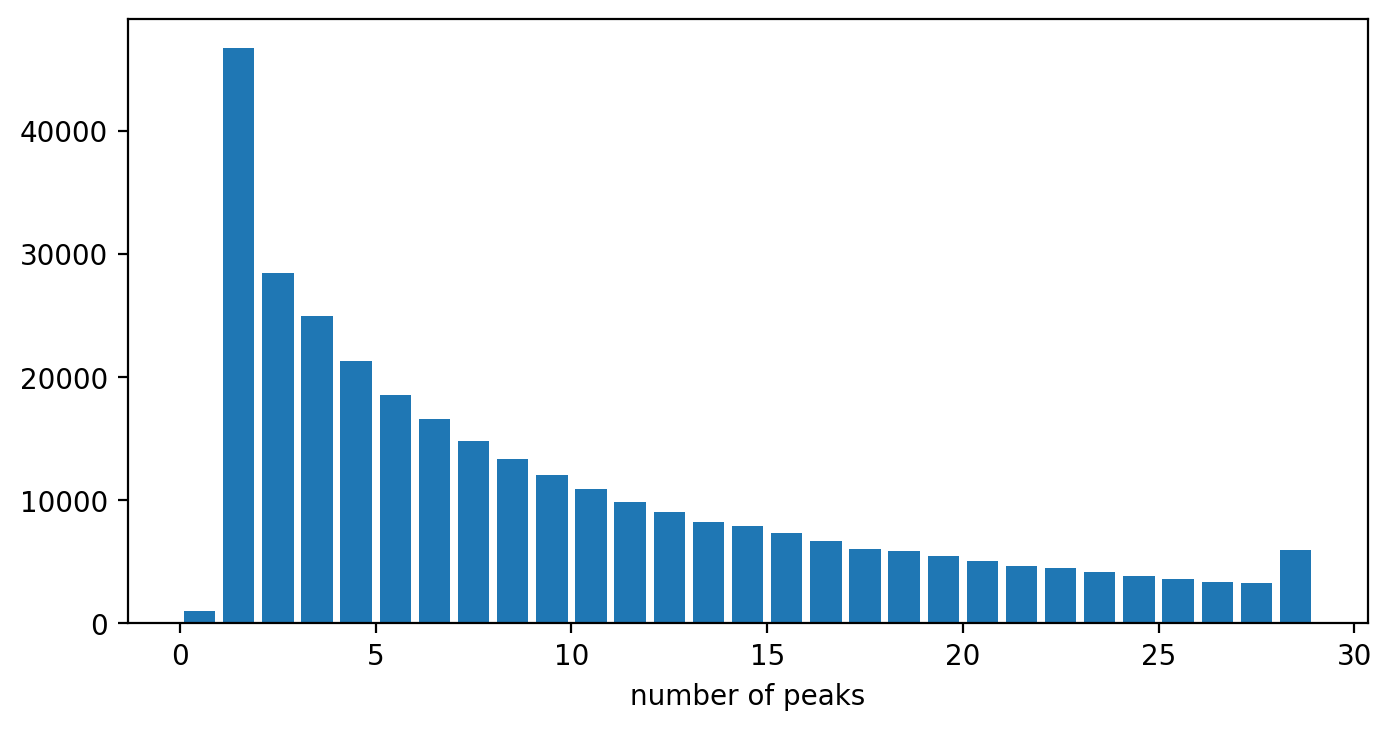

In [23]:
import numpy as np
from matplotlib import pyplot as plt

def plot_nr_of_peaks_distribution(spectra):
    number_of_peaks = np.array([len(s.peaks) for s in spectra])

    plt.figure(figsize=(8,4), dpi=200)
    plt.hist(number_of_peaks, np.arange(0, 30, 1),
            rwidth=0.8)
    plt.xlabel("number of peaks")
    plt.show()
    return number_of_peaks


number_of_peaks = plot_nr_of_peaks_distribution(gnps_spectra)

In [24]:
print(f"{np.sum(number_of_peaks < 5)} spectra have < 5 peaks")

122394 spectra have < 5 peaks


In [25]:
def normalize_and_filter_peaks(spectrum):
    spectrum = msfilters.normalize_intensities(spectrum)
    spectrum = msfilters.select_by_relative_intensity(spectrum, 0.001, 1)
    spectrum = msfilters.select_by_mz(spectrum, mz_from=0.0, mz_to=1000.0)
    spectrum = msfilters.reduce_to_number_of_peaks(spectrum, n_max = 500)
    spectrum = msfilters.require_minimum_number_of_peaks(spectrum, n_required=3)
    return spectrum

In [26]:
from tqdm.notebook import tqdm

gnps_spectra = [normalize_and_filter_peaks(s) for s in tqdm(gnps_spectra)]

  0%|          | 0/480947 [00:00<?, ?it/s]

In [29]:
gnps_spectra = [s for s in gnps_spectra if s is not None]
count_annotations(gnps_spectra)

nr_of_spectra: 403427
Inchis: 351329 -- 26452 unique
Smiles: 350923 -- 36854 unique
Inchikeys: 350890 -- 22363 unique (first 14 characters)
Spectra with less than 3 peaks: 0
Spectra with more than 500 peaks: 0


In [30]:
pickle.dump(gnps_spectra,
           open(os.path.join(path_data, "ALL_GNPS_15_12_2021_removed_peaks.pickle"), "wb"))

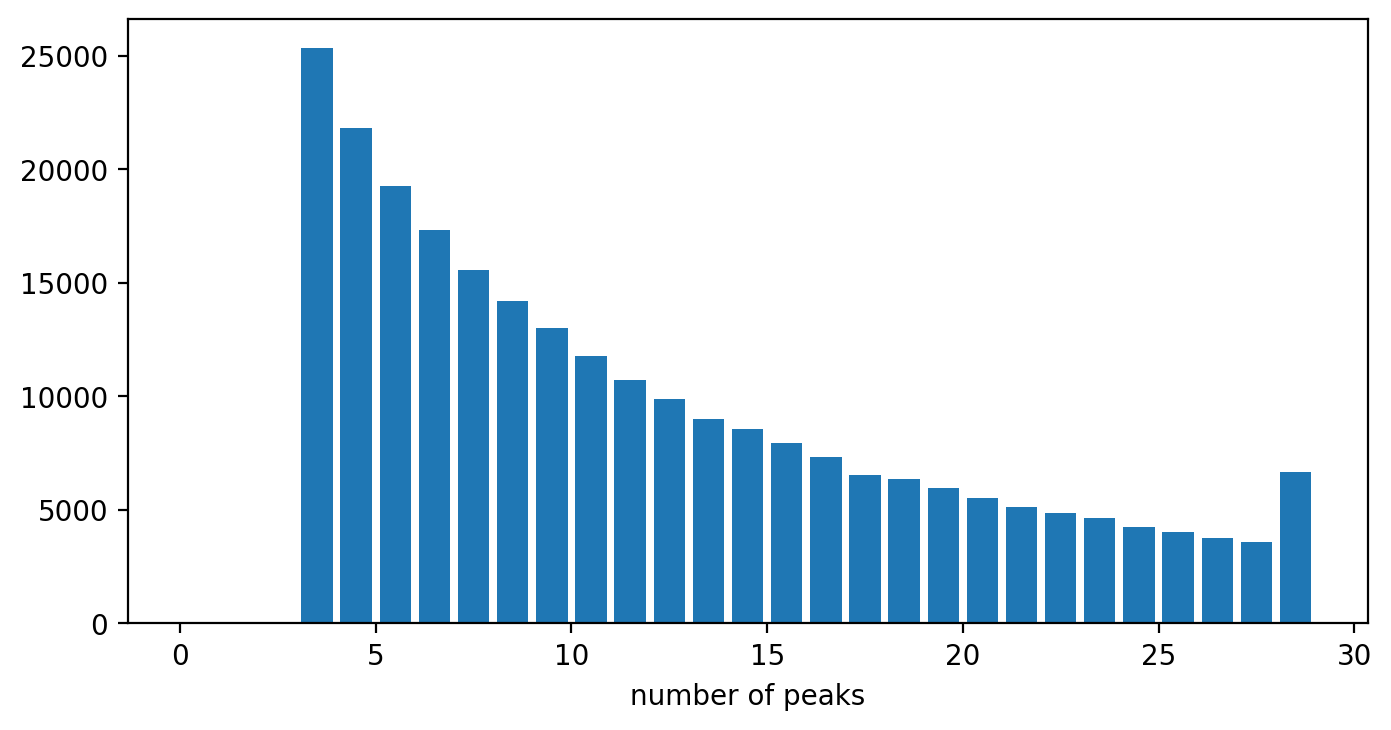

array([211, 197,  29, ...,   3,   3,   3])

In [32]:
plot_nr_of_peaks_distribution(gnps_spectra)

# Use pubchem to add missing inchikeys
52561 spectra do not have a inchikey. 

In [4]:
outfile = os.path.join(path_data, "ALL_GNPS_15_12_2021_removed_peaks.pickle")
with open(outfile, 'rb') as file:
    gnps_spectra = pickle.load(file)

In [5]:
count_annotations(gnps_spectra)

nr_of_spectra: 403427
Inchis: 351329 -- 26452 unique
Smiles: 350923 -- 36854 unique
Inchikeys: 350890 -- 22363 unique (first 14 characters)
Spectra with less than 3 peaks: 0
Spectra with more than 500 peaks: 0


### Run matchmsextras.pubchem_lookup
- For spectra missing a valid InChIKey, `pubchem_lookup()` will search for matchs on PubChem based on compound name and molecular weight.

In [28]:
spectra_with_missing_inchi_or_smiles = []
for spectrum in gnps_spectra:
    inchikey = spectrum.get("inchikey") 
    if inchikey is None or len(inchikey) < 14:
        spectra_with_missing_inchi_or_smiles.append(spectrum)
    else:
        smiles = spectrum.get("smiles")
        if smiles is None or len(smiles) < 1:
            spectra_with_missing_inchi_or_smiles.append(spectrum)
print(len(spectra_with_missing_inchi_or_smiles))

52532


In [29]:
count_annotations(spectra_with_missing_inchi_or_smiles)

nr_of_spectra: 52532
Inchis: 445 -- 102 unique
Smiles: 39 -- 33 unique
Inchikeys: 6 -- 4 unique (first 14 characters)


In [15]:
import logging
import re
import pubchempy as pcp
import numpy as np
from matchms.utils import is_valid_inchikey


logger = logging.getLogger("matchms")


def pubchem_metadata_lookup(spectrum_in, name_search_depth=10, match_precursor_mz=False,
                            formula_search=False,
                            mass_tolerance=2.0,
                            allowed_differences=[(18.03, 0.01)],
                            min_formula_length=6,
                            formula_search_depth=25,
                            verbose=2):
    """

    Parameters
    ----------
    spectrum_in
        Matchms type spectrum as input.
    name_search_depth: int
        How many of the most relevant name matches to explore deeper. Default = 10.

    """
    if spectrum_in is None:
        return None

    if is_valid_inchikey(spectrum_in.get("inchikey")):
        return spectrum_in

    spectrum = spectrum_in.clone()

    def _plausible_name(compound_name):
        return (isinstance(compound_name, str) and len(compound_name) > 4)

    compound_name = spectrum.get("compound_name")
    if not _plausible_name(compound_name):
        logger.info("No plausible compound name found (%s)", compound_name)
        return spectrum

    # Start pubchem search
    inchi = spectrum.get("inchi")
    precursor_mz = spectrum.get("precursor_mz")
    if isinstance(precursor_mz, np.ndarray):
        precursor_mz = precursor_mz[0]
    formula = spectrum.get("formula")

    # 1) Search for matching compound name
    results_pubchem = pubchem_name_search(compound_name, name_search_depth=name_search_depth,
                                          verbose=verbose)

    if len(results_pubchem) > 0:
        logger.info("Found potential matches for compound name (%s) on PubChem",
                   compound_name)

        # 1a) Search for matching inchi
        if likely_has_inchi(inchi):
            inchi_pubchem, inchikey_pubchem, smiles_pubchem = find_pubchem_inchi_match(results_pubchem, inchi,
                                                                                       verbose=verbose)
        # 1b) Search for matching parent mass
        if not likely_has_inchi(inchi) or inchikey_pubchem is None:
            inchi_pubchem, inchikey_pubchem, smiles_pubchem = find_pubchem_mass_match(results_pubchem,
                                                                                      precursor_mz,
                                                                                      given_mass="parent mass",
                                                                                      mass_tolerance=mass_tolerance,
                                                                                      allowed_differences=allowed_differences,
                                                                                      verbose=verbose)

        # 1c) Search for matching precursor mass (optional)
        if match_precursor_mz and inchikey_pubchem is None:
            precursor_mz = spectrum.get("precursor_mz")
            inchi_pubchem, inchikey_pubchem, smiles_pubchem = find_pubchem_mass_match(results_pubchem,
                                                                                      precursor_mz,
                                                                                      given_mass="precursor mass",
                                                                                      mass_tolerance=mass_tolerance,
                                                                                      allowed_differences=allowed_differences,
                                                                                      verbose=verbose)

        if inchikey_pubchem is not None and inchi_pubchem is not None:
            logger.info("Matching compound name: %s", compound_name)
            spectrum.set("inchikey", inchikey_pubchem)
            spectrum.set("inchi", inchi_pubchem)
            spectrum.set("smiles", smiles_pubchem)
            return spectrum

        if verbose >= 2:
            logger.info("No matches found for compound name: %s", compound_name)

    else:
        logger.info("No matches for compound name (%s) on PubChem",
                   compound_name)
    # 2) Search for matching formula
    if formula_search and formula and len(formula) >= min_formula_length:
        results_pubchem = pubchem_formula_search(formula, formula_search_depth=formula_search_depth,
                                                 verbose=verbose)

        if len(results_pubchem) > 0:
            logger.info("Found potential matches for formula (%s) on PubChem",
                       formula)
            # 2a) Search for matching inchi
            if likely_has_inchi(inchi):
                inchi_pubchem, inchikey_pubchem, smiles_pubchem = find_pubchem_inchi_match(results_pubchem, inchi,
                                                                                           verbose=verbose)
            # 2b) Search for matching parent mass
            if inchikey_pubchem is None:
                inchi_pubchem, inchikey_pubchem, smiles_pubchem = find_pubchem_mass_match(results_pubchem,
                                                                                          precursor_mz,
                                                                                          given_mass="parent mass",
                                                                                          mass_tolerance=mass_tolerance,
                                                                                          allowed_differences=allowed_differences,
                                                                                          verbose=verbose)
            # 2c) Search for matching precursor mass (optional)
            if match_precursor_mz and inchikey_pubchem is None:
                precursor_mz = spectrum.get("precursor_mz")
                inchi_pubchem, inchikey_pubchem, smiles_pubchem = find_pubchem_mass_match(results_pubchem,
                                                                                          precursor_mz,
                                                                                          given_mass="precursor mass",
                                                                                          mass_tolerance=mass_tolerance,
                                                                                          allowed_differences=allowed_differences,
                                                                                          verbose=verbose)
            if inchikey_pubchem is not None and inchi_pubchem is not None:
                logger.info("Matching formula: %s", formula)
                if verbose >= 1:
                    logger.info("Matching formula: %s", formula)
                spectrum.set("inchikey", inchikey_pubchem)
                spectrum.set("inchi", inchi_pubchem)
                spectrum.set("smiles", smiles_pubchem)
                return spectrum

            if verbose >= 2:
                logger.info("No matches found for formula: %s", formula)
        else:
            logger.info("No matches for formula (%s) on PubChem",
                       formula)

    return spectrum


def likely_has_inchi(inchi):
    """Quick test to avoid excess in-depth testing"""
    if inchi is None:
        return False
    inchi = inchi.strip('"')
    regexp = r"(InChI=1|1)(S\/|\/)[0-9, A-Z, a-z,\.]{2,}\/(c|h)[0-9]"
    if not re.search(regexp, inchi):
        return False
    return True


def likely_inchi_match(inchi_1, inchi_2, min_agreement=3):
    """Try to match defective inchi to non-defective ones.

    Compares inchi parts seperately. Match is found if at least the first
    'min_agreement' parts are a good enough match.
    The main 'defects' this method accounts for are missing '-' in the inchi.
    In addition, differences between '-', '+', and '?'will be ignored.

    Parameters
    ----------
    inchi_1: str
        inchi of molecule.
    inchi_2: str
        inchi of molecule.
    min_agreement: int
        Minimum number of first parts that MUST be a match between both input
        inchi to finally consider it a match. Default is min_agreement=3.
    """
    if min_agreement < 2:
        logger.warning("Warning! 'min_agreement' < 2 has no discriminative power. Should be => 2.")
    if min_agreement == 2:
        logger.warning("Warning! 'min_agreement' == 2 has little discriminative power",
                       "(only looking at structure formula. Better use > 2.")
    agreement = 0

    # Remove spaces and '"' to account for different notations.
    # Remove everything with little discriminative power.
    ignore_lst = ['"', ' ', '-', '+', '?']
    for ignore in ignore_lst:
        inchi_1 = inchi_1.replace(ignore, '')
        inchi_2 = inchi_2.replace(ignore, '')

    # Split inchi in parts.
    inchi_1_parts = inchi_1.split('/')
    inchi_2_parts = inchi_2.split('/')

    # Check if both inchi have sufficient parts (seperated by '/')
    if len(inchi_1_parts) >= min_agreement and len(
            inchi_2_parts) >= min_agreement:
        # Count how many parts agree well
        for i in range(min_agreement):
            agreement += (inchi_1_parts[i] == inchi_2_parts[i])

    return bool(agreement == min_agreement)


def likely_inchikey_match(inchikey_1, inchikey_2, min_agreement=1):
    """Try to match inchikeys.

    Compares inchikey parts seperately. Match is found if at least the first
    'min_agreement' parts are a good enough match.

    Parameters
    ----------
    inchikey_1: str
        inchikey of molecule.
    inchikey_2: str
        inchikey of molecule.
    min_agreement: int
        Minimum number of first parts that MUST be a match between both input
        inchikey to finally consider it a match. Default is min_agreement=1.
    """
    if min_agreement not in [1, 2, 3]:
        logger.error("Warning! 'min_agreement' should be 1, 2, or 3.")
    agreement = 0

    # Harmonize strings
    inchikey_1 = inchikey_1.upper().replace('"', '').replace(' ', '')
    inchikey_2 = inchikey_2.upper().replace('"', '').replace(' ', '')

    # Split inchikey in parts.
    inchikey_1_parts = inchikey_1.split('-')
    inchikey_2_parts = inchikey_2.split('-')

    # Check if both inchikey have sufficient parts (seperated by '/')
    if len(inchikey_1_parts) >= min_agreement and len(
            inchikey_2_parts) >= min_agreement:
        # Count how many parts mostly agree
        for i in range(min_agreement):
            agreement += (inchikey_1_parts[i] == inchikey_2_parts[i])

    return agreement == min_agreement


def pubchem_name_search(compound_name: str, name_search_depth=10, verbose=1):
    """Search pubmed for compound name"""
    results_pubchem = pcp.get_compounds(compound_name,
                                        'name',
                                        listkey_count=name_search_depth)
    if len(results_pubchem) == 0 and "_" in compound_name:
        results_pubchem = pcp.get_compounds(compound_name.replace("_", " "),
                                            'name',
                                            listkey_count=name_search_depth)
    if len(results_pubchem) == 0:
        return []

    logger.debug("Found at least %s compounds of that name on pubchem.", len(results_pubchem))
    return results_pubchem


def pubchem_formula_search(compound_formula: str, formula_search_depth=25, verbose=1):
    """Search pubmed for compound formula"""
    sids_pubchem = pcp.get_sids(compound_formula,
                                'formula',
                                listkey_count=formula_search_depth)

    results_pubchem = []
    for sid in sids_pubchem:
        result = pcp.Compound.from_cid(sid['CID'])
        results_pubchem.append(result)

    logger.debug("Found at least %s compounds of with formula: %s.",
                 len(results_pubchem), compound_formula)
    return results_pubchem


def find_pubchem_inchi_match(results_pubchem,
                             inchi,
                             min_inchi_match=3,
                             verbose=1):
    """Searches pubmed matches for inchi match.
    Then check if inchi can be matched to (defective) input inchi.


    Outputs found inchi and found inchikey (will be None if none is found).

    Parameters
    ----------
    results_pubchem: List[dict]
        List of name search results from Pubchem.
    inchi: str
        Inchi (correct, or defective...). Set to None to ignore.
    min_inchi_match: int
        Minimum number of first parts that MUST be a match between both input
        inchi to finally consider it a match. Default is min_inchi_match=3.
    """

    inchi_pubchem = None
    inchikey_pubchem = None
    smiles_pubchem = None

    # Loop through first 'name_search_depth' results found on pubchem. Stop once first match is found.
    for result in results_pubchem:
        inchi_pubchem = '"' + result.inchi + '"'
        inchikey_pubchem = result.inchikey
        smiles_pubchem = result.isomeric_smiles
        if smiles_pubchem is None:
            smiles_pubchem = result.canonical_smiles

        match_inchi = likely_inchi_match(inchi, inchi_pubchem,
                                         min_agreement=min_inchi_match)

        if match_inchi:
            logger.info("Matching inchi: %s", inchi)
            if verbose >= 1:
                logger.info("Found matching compound for inchi: %s (Pubchem: %s)",
                            inchi, inchi_pubchem)
            break

    if not match_inchi:
        inchi_pubchem = None
        inchikey_pubchem = None
        smiles_pubchem = None

        if verbose >= 2:
            logger.info("No matches found for inchi %s.", inchi)

    return inchi_pubchem, inchikey_pubchem, smiles_pubchem


def find_pubchem_mass_match(results_pubchem,
                            precursor_mz,
                            mass_tolerance,
                            given_mass="parent mass",
                            allowed_differences=[(18.03, 0.01)],
                            verbose=1):
    """Searches pubmed matches for inchi match.
    Then check if inchi can be matched to (defective) input inchi.


    Outputs found inchi and found inchikey (will be None if none is found).

    Parameters
    ----------
    results_pubchem: List[dict]
        List of name search results from Pubchem.
    precursor_mz: float
        Spectrum"s guessed parent mass.
    mass_tolerance: float
        Acceptable mass difference between query compound and pubchem result.
    given_mass
        String to specify the type of the given mass (e.g. "parent mass").
    """
    inchi_pubchem = None
    inchikey_pubchem = None
    smiles_pubchem = None
    mass_difference = None
    lowest_mass_difference = [np.inf, None]

    for result in results_pubchem:
        inchi_pubchem = '"' + result.inchi + '"'
        inchikey_pubchem = result.inchikey
        smiles_pubchem = result.isomeric_smiles
        if smiles_pubchem is None:
            smiles_pubchem = result.canonical_smiles

        pubchem_mass = float(results_pubchem[0].exact_mass)
        mass_difference = np.abs(pubchem_mass - precursor_mz)
        if mass_difference < lowest_mass_difference[0]:
            lowest_mass_difference[0] = mass_difference
            lowest_mass_difference[1] = inchi_pubchem
        match_mass = (mass_difference <= mass_tolerance)
        for diff in allowed_differences:
            match_mass = match_mass or np.isclose(mass_difference, diff[0], atol=diff[1])

        if match_mass:
            logger.info("Matching molecular weight (%s vs %s of %s)",
                        pubchem_mass, given_mass, precursor_mz)
            break

    if not match_mass:
        inchi_pubchem = None
        inchikey_pubchem = None
        smiles_pubchem = None

        logger.info("No matching molecular weight (best mass difference was %s for inchi: %s)",
                    lowest_mass_difference[0], lowest_mass_difference[1])

    return inchi_pubchem, inchikey_pubchem, smiles_pubchem


In [7]:
from matchms.logging_functions import set_matchms_logger_level, add_logging_to_file

set_matchms_logger_level("INFO")
log_file = os.path.join(path_data, "pubchem_matching_17_12_2021.log")
add_logging_to_file(log_file, loglevel="INFO",
                   remove_stream_handlers=True)

In [8]:
logger.info('Start running pubchem search --------------------')

In [17]:
for i, s in enumerate(tqdm(gnps_spectra)):
    compound_name = s.get("compound_name")
    if compound_name.endswith(";") or compound_name.endswith("; "):
        s.set("compound_name", compound_name.strip("; "))

  0%|          | 0/403427 [00:00<?, ?it/s]

In [16]:
#from matchmsextras.pubchem_lookup import pubchem_metadata_lookup
from tqdm.notebook import tqdm

gnps_spectra_annotated_with_pubchem = []
for i, s in enumerate(tqdm(gnps_spectra)):
    searched_spectrum = pubchem_metadata_lookup(s,
                                                mass_tolerance=2.0,
                                                allowed_differences=[(18.03, 0.01),
                                                                    (18.01, 0.01)],
                                                name_search_depth=15)
    gnps_spectra_annotated_with_pubchem.append(searched_spectrum)

  0%|          | 0/403427 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
i, len(gnps_spectra_annotated_with_pubchem)

(403426, 35302)

In [21]:
gnps_spectra_annotated_with_pubchem[-1].get("compound_name")

'Diisooctyl phthalate'

In [29]:
gnps_spectra_annotated_with_pubchem[-1].get("inchikey")

'IJFPVINAQGWBRJ-UHFFFAOYSA-N'

In [28]:
print([s.get("compound_name") for s in gnps_spectra[35301:35303]])

['Diisooctyl phthalate', 'Chicoric acid']


In [ ]:
for i, s in enumerate(tqdm(gnps_spectra[35302:])):
    searched_spectrum = pubchem_metadata_lookup(s,
                                                mass_tolerance=2.0,
                                                allowed_differences=[(18.03, 0.01),
                                                                    (18.01, 0.01)],
                                                name_search_depth=15)
    gnps_spectra_annotated_with_pubchem.append(searched_spectrum)

  0%|          | 0/368125 [00:00<?, ?it/s]

In [ ]:
known_name_changes = {"DihydrofusarinC": "Dihydrofusarin C",
                      "FusarinA": "Fusarin A",
                      "FusarinC": "Fusarin C",
                      "FusarinD": "Fusarin D",
                      "epi-FusarinC": "epi-Fusarin C",
                      "AnhydrocyanobacterinB": "Anhydrocyanobacterin B"}


In [14]:
pickle.dump(gnps_spectra_annotated_with_pubchem,
           open(os.path.join(path_data, "ALL_GNPS_15_12_2021_inchikeys_from_pubchem.pickle"), "wb"))

In [18]:
outfile = os.path.join(path_data, "ALL_GNPS_15_12_2021_inchikeys_from_pubchem.pickle")
with open(outfile, 'rb') as file:
    gnps_spectra_annotated_with_pubchem = pickle.load(file)

In [19]:
count_annotations(gnps_spectra_annotated_with_pubchem)

nr_of_spectra: 403427
Inchis: 352301 -- 27057 unique
Smiles: 352278 -- 37325 unique
Inchikeys: 352257 -- 22632 unique (first 14 characters)
Spectra with less than 3 peaks: 0
Spectra with more than 500 peaks: 0


For some reason (I guess changes in the raw data) I suddently encountered many compound names with ";" at the end (or between name and adduct). Those resulted in pubchem not finding any entries. 

This was added as a minor fix to matchms and will here be done manually in the following code block

In [20]:
for i, s in enumerate(tqdm(gnps_spectra_annotated_with_pubchem)):
    compound_name = s.get("compound_name")
    if compound_name.endswith(";") or compound_name.endswith("; "):
        print(compound_name)
        s.set("compound_name", compound_name.strip("; "))
        s = pubchem_metadata_lookup(s, name_search_depth=10)

  0%|          | 0/403427 [00:00<?, ?it/s]

PC(16:1/0:0);
PC(16:1/0:0);
PC(18:2/0:0);
PC(18:2/0:0);
PC(18:2/0:0);
PC(18:2/0:0);
PC(0:0/18:1);
PC(0:0/18:1);
PC(0:0/18:1);
PC(0:0/18:1);
PC(0:0/20:4);
PC(0:0/20:4);
PC(16:2/16:1);
PC(16:2/16:1);
GalCer(d18:2/16:2);
GalCer(d18:2/16:2);
PC(16:2/18:2);
PC(16:2/18:2);
PC(16:1/17:2);
PC(16:1/17:2);
PC(14:0/16:1);
PC(14:0/16:1);
GalCer(d18:2/16:1);
GalCer(d18:2/16:1);
PC(16:1/16:1);
PC(16:1/16:1);
PC(17:2/18:2);
PC(17:2/18:2);
PC(16:1/18:2);
PC(16:1/18:2);
GalCer(d18:2/16:1);
GalCer(d18:2/16:1);
PC(18:2/18:2);
PC(18:2/18:2);
PE(16:1/18:1);
PE(16:1/18:1);
PC(16:1/18:1);
PC(16:1/18:1);
PC(16:0/16:1);
PC(16:0/16:1);
PC(18:1/18:2);
PC(18:1/18:2);
DG(16:1/0:0/16:1);
DG(16:1/0:0/16:1);
Cer(d18:0/16:0(2OH));
Cer(d18:0/16:0(2OH));
DG(16:1/18:2/0:0);
DG(16:1/18:2/0:0);
DG(18:2/0:0/18:2);
DG(18:2/0:0/18:2);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
PC(18:1/18:1);
PC(18:1/18:1);
DG(14:0/18:1/0:0);
DG(14:0/18:1/0:0);
DG(16:1/18:1/0:0);
DG(16:1/18:1/0:0);
DG(18:1/18:2/0:0);
DG(18:1/18:2/0:0);
DG(16:0/18:1/0:0

TG(15:0/18:1/18:2);
TG(15:0/18:1/18:2);
TG(17:1/18:1/18:2);
TG(17:1/18:1/18:2);
TG(16:1/18:1/18:1);
TG(16:1/18:1/18:1);
TG(16:0/16:0/16:1);
TG(16:0/16:0/16:1);
TG(18:1/18:1/18:2);
TG(18:1/18:1/18:2);
TG(16:0/18:1/18:1);
TG(16:0/18:1/18:1);
TG(18:1/18:1/18:1);
TG(18:1/18:1/18:1);
TG(16:0/16:0/18:1);
TG(16:0/16:0/18:1);
TG(16:0/16:0/16:0);
TG(16:0/16:0/16:0);
TG(16:0/17:1/18:0);
TG(16:0/17:1/18:0);
TG(17:1/18:0/18:1);
TG(17:1/18:0/18:1);
TG(18:0/18:1/18:1);
TG(18:0/18:1/18:1);
TG(16:0/18:0/18:1);
TG(16:0/18:0/18:1);
TG(18:1/18:2/20:0);
TG(18:1/18:2/20:0);
TG(18:0/18:0/18:1);
TG(18:0/18:0/18:1);
TG(18:1/18:2/22:0);
TG(18:1/18:2/22:0);
TG(18:0/18:1/20:0);
TG(18:0/18:1/20:0);
TG(18:0/18:1/22:0);
TG(18:0/18:1/22:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(18:2/0:0);
PC(18:2/0:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(18:2/0:0);
PC(18:2/0:0);
PC(0:0/18:1);
PC(0:0/18:1);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/18:1);
PC(0:0/18:1);
PC(0:0/18:0);
PC(0:0/18:0);
PC(16:2/18:2);
PC(16:2/18:2);
GalCer(d18:2/16:1);
GalCer

PC(18:1/18:1);
PC(16:0/18:1);
PC(16:0/18:1);
DG(18:1/18:2/0:0);
DG(18:1/18:2/0:0);
Cer(d20:1/24:0);
Cer(d20:1/24:0);
DG(16:0/18:1/0:0);
DG(16:0/18:1/0:0);
DG(18:1/0:0/18:1);
DG(18:1/0:0/18:1);
TG(10:0/12:0/14:0);
TG(10:0/12:0/14:0);
TG(16:1/18:2/18:2);
TG(16:1/18:2/18:2);
TG(18:1/18:2/18:2);
TG(18:1/18:2/18:2);
TG(16:0/16:1/16:1);
TG(16:0/16:1/16:1);
TG(16:0/16:1/18:2);
TG(16:0/16:1/18:2);
TG(16:0/16:0/17:2);
TG(16:0/16:0/17:2);
TG(16:0/16:1/18:1);
TG(16:0/16:1/18:1);
TG(16:1/18:1/18:1);
TG(16:1/18:1/18:1);
TG(16:0/16:0/16:1);
TG(16:0/16:0/16:1);
TG(18:1/18:1/18:2);
TG(18:1/18:1/18:2);
TG(16:0/18:1/18:1);
TG(16:0/18:1/18:1);
TG(18:1/18:1/18:1);
TG(18:1/18:1/18:1);
TG(17:0/17:0/17:1);
TG(17:0/17:0/17:1);
TG(18:0/18:1/18:1);
TG(18:0/18:1/18:1);
TG(16:0/18:0/18:1);
TG(16:0/18:0/18:1);
TG(17:1/18:0/18:0);
TG(17:1/18:0/18:0);
TG(18:0/18:0/18:1);
TG(18:0/18:0/18:1);
TG(18:1/18:2/22:0);
TG(18:1/18:2/22:0);
TG(18:1/18:1/22:0);
TG(18:1/18:1/22:0);
TG(16:0/18:1/22:0);
TG(16:0/18:1/22:0);
TG(18:0

SM(d18:1/15:0);
PC(14:0/16:1);
PC(14:0/16:1);
PC(14:0/20:4);
PC(14:0/20:4);
PC(16:1/16:1);
PC(16:1/16:1);
PC(20:4/22:6);
PC(20:4/22:6);
PC(14:0/18:1);
PC(14:0/18:1);
SM(d16:1/17:0);
SM(d16:1/17:0);
PC(18:2/22:6);
PC(18:2/22:6);
PC(16:1/22:6);
PC(16:1/22:6);
PC(14:0/15:0);
PC(14:0/15:0);
PC(16:1/20:4);
PC(16:1/20:4);
PC(16:1/18:2);
PC(16:1/18:2);
PC(15:0/16:1);
PC(15:0/16:1);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(20:4/20:4);
PC(20:4/20:4);
PC(18:2/20:4);
PC(18:2/20:4);
PC(14:0/18:2);
PC(14:0/18:2);
PC(15:0/20:4);
PC(15:0/20:4);
PC(16:0/18:3);
PC(16:0/18:3);
PE(18:2/20:4);
PE(18:2/20:4);
PC(15:0/18:1);
PC(15:0/18:1);
SM(d16:1/18:0);
SM(d16:1/18:0);
PE(16:0/20:5);
PE(16:0/20:5);
PC(20:3/22:6);
PC(20:3/22:6);
PC(14:0/16:0);
PC(14:0/16:0);
SM(d18:2/18:0);
SM(d18:2/18:0);
PC(20:3/20:4);
PC(20:3/20:4);
PC(17:1/18:2);
PC(17:1/18:2);
PC(16:0/16:0);
PC(16:0/16:0);
PC(15:0/18:2);
PC(15:0/18:2);
PC(18:2/18:2);
PC(18:2/18:2);
PC(16:1/18:1);
PC(16:1/18:1);
SM(d18:0/16:0);
SM(d18:0/16:0);
PC(16:0/22:6);

DG(16:0/22:6/0:0);
SM(d18:1/20:0);
SM(d18:1/20:0);
PC(O-16:0/18:1);
PC(O-16:0/18:1);
PE(P-18:0/22:5);
PE(P-18:0/22:5);
PE(P-18:0/20:4);
PE(P-18:0/20:4);
PC(18:0/22:4);
PC(18:0/22:4);
DG(18:1/20:4/0:0);
DG(18:1/20:4/0:0);
DG(18:1/18:2/0:0);
DG(18:1/18:2/0:0);
SM(d18:2/24:1);
SM(d18:2/24:1);
PE(P-18:0/20:3);
PE(P-18:0/20:3);
PC(18:0/18:1);
PC(18:0/18:1);
PE(P-18:0/22:5);
PE(P-18:0/22:5);
PE(P-18:0/16:0);
PE(P-18:0/16:0);
Cer(d18:0/18:0);
Cer(d18:0/18:0);
PE(P-18:0/22:4);
PE(P-18:0/22:4);
DG(16:0/0:0/16:0);
DG(16:0/0:0/16:0);
DG(16:0/22:4/0:0);
DG(16:0/22:4/0:0);
SM(d17:1/24:1);
SM(d17:1/24:1);
DG(16:0/18:1/0:0);
DG(16:0/18:1/0:0);
SM(d17:1/22:0);
SM(d17:1/22:0);
DG(18:0/22:6/0:0);
DG(18:0/22:6/0:0);
PE(P-18:0/18:1);
PE(P-18:0/18:1);
DG(18:0/22:5/0:0);
DG(18:0/22:5/0:0);
DG(18:0/20:4/0:0);
DG(18:0/20:4/0:0);
Cer(d18:2/22:0);
Cer(d18:2/22:0);
SM(d18:1/22:0);
SM(d18:1/22:0);
DG(18:0/20:3/0:0);
DG(18:0/20:3/0:0);
Cer(d18:0/20:0);
Cer(d18:0/20:0);
DG(16:0/18:0/0:0);
DG(16:0/18:0/0:0);
DG(18:0

SQDG(16:0/16:0);
SQDG(16:0/16:0);
PC(O-16:0/20:5);
PC(O-16:0/20:5);
PC(18:1/20:4);
PC(18:1/20:4);
DGTSA(14:0/18:1);
DGTSA(14:0/18:1);
DGTSA(14:0/16:0);
DGTSA(14:0/16:0);
GalCer(d18:2/18:1);
GalCer(d18:2/18:1);
PC(16:0/20:4);
PC(16:0/20:4);
PC(17:0/20:4);
PC(17:0/20:4);
PC(16:0/16:0);
PC(16:0/16:0);
PC(18:1/20:4);
PC(18:1/20:4);
PC(18:1/20:2);
PC(18:1/20:2);
DGTSA(16:0/16:0);
DGTSA(16:0/16:0);
DG(20:4/0:0/20:4);
DG(20:4/0:0/20:4);
DG(16:0/18:3/0:0);
DG(16:0/18:3/0:0);
DG(16:0/22:6/0:0);
DG(16:0/22:6/0:0);
DG(18:1/20:4/0:0);
DG(18:1/20:4/0:0);
CoQ9;
CoQ9;
TG(20:4/20:4/20:5);
TG(20:4/20:4/20:5);
TG(16:0/18:4/22:6);
TG(16:0/18:4/22:6);
TG(18:3/20:4/20:4);
TG(18:3/20:4/20:4);
TG(18:1/22:6/22:6);
TG(18:1/22:6/22:6);
TG(14:0/16:0/18:3);
TG(14:0/16:0/18:3);
TG(14:0/16:0/16:1);
TG(14:0/16:0/16:1);
TG(12:0/16:0/16:0);
TG(12:0/16:0/16:0);
TG(16:0/16:1/16:1);
TG(16:0/16:1/16:1);
TG(15:0/16:0/20:4);
TG(15:0/16:0/20:4);
TG(16:0/16:0/16:1);
TG(16:0/16:0/16:1);
TG(14:0/16:0/16:0);
TG(14:0/16:0/16:0);


TG(18:4/20:5/20:5);
TG(18:3/18:4/20:5);
TG(18:3/18:4/20:5);
TG(20:5/20:5/20:5);
TG(20:5/20:5/20:5);
TG(13:0/13:0/13:0);
TG(13:0/13:0/13:0);
TG(16:1/20:5/20:5);
TG(16:1/20:5/20:5);
TG(20:4/20:5/20:5);
TG(20:4/20:5/20:5);
TG(18:3/20:4/20:5);
TG(18:3/20:4/20:5);
TG(13:0/13:0/14:0);
TG(13:0/13:0/14:0);
CoQ9;
CoQ9;
TG(13:0/13:0/15:0);
TG(13:0/13:0/15:0);
TG(14:0/16:1/18:3);
TG(14:0/16:1/18:3);
TG(18:2/20:4/20:5);
TG(18:2/20:4/20:5);
TG(16:1/16:1/18:3);
TG(16:1/16:1/18:3);
TG(16:1/16:1/16:1);
TG(16:1/16:1/16:1);
TG(14:0/16:1/16:1);
TG(14:0/16:1/16:1);
TG(18:1/20:4/20:5);
TG(18:1/20:4/20:5);
TG(13:0/15:0/15:0);
TG(13:0/15:0/15:0);
TG(14:0/15:0/16:1);
TG(14:0/15:0/16:1);
CoQ10;
CoQ10;
TG(14:0/14:0/16:0);
TG(14:0/14:0/16:0);
TG(16:0/16:1/17:0);
TG(16:0/16:1/17:0);
TG(16:0/16:0/20:1);
TG(16:0/16:0/20:1);
SQDG(14:0/16:1);
SQDG(14:0/16:1);
SQDG(14:0/16:1);
SQDG(14:0/16:1);
SQDG(16:0/16:2);
SQDG(16:0/16:2);
DGDG(16:2/18:3);
DGDG(16:2/18:3);
SQDG(16:0/14:0);
SQDG(16:0/14:0);
SQDG(16:0/18:3);
SQDG(16

DG(20:4/0:0/20:4);
DG(20:4/0:0/20:4);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
DG(16:0/20:5/0:0);
DG(16:0/20:5/0:0);
DGTSA(17:0/17:0);
DGTSA(17:0/17:0);
DG(18:1/20:5/0:0);
DG(18:1/20:5/0:0);
DG(18:2/0:0/18:2);
DG(18:2/0:0/18:2);
PC(18:1/19:1);
PC(18:1/19:1);
DG(18:1/18:2/0:0);
DG(18:1/18:2/0:0);
PE(19:1/19:1);
PE(19:1/19:1);
PC(19:1/19:1);
PC(19:1/19:1);
Cer(d20:0/18:0(2OH));
Cer(d20:0/18:0(2OH));
TG(18:2/18:4/18:4);
TG(18:2/18:4/18:4);
TG(20:5/20:5/20:5);
TG(20:5/20:5/20:5);
TG(14:1/14:1/16:1);
TG(14:1/14:1/16:1);
TG(18:3/18:3/18:3);
TG(18:3/18:3/18:3);
TG(20:4/20:5/20:5);
TG(20:4/20:5/20:5);
TG(14:1/16:1/18:3);
TG(14:1/16:1/18:3);
TG(16:1/20:5/20:5);
TG(16:1/20:5/20:5);
TG(20:5/22:6/22:6);
TG(20:5/22:6/22:6);
TG(16:1/16:1/18:4);
TG(16:1/16:1/18:4);
TG(12:0/16:1/16:1);
TG(12:0/16:1/16:1);
TG(14:1/16:1/16:1);
TG(14:1/16:1/16:1);
CoQ9;
CoQ9;
TG(22:6/22:6/22:6);
TG(22:6/22:6/22:6);
TG(15:1/16:1/16:1);
TG(15:1/16:1/16:1);
TG(16:1/16:1/18:3);
TG(16:1/16:1/18:3);
TG(16:1/20:4/20:4);
TG(16:1/20:4/2

DG(16:1/20:4/0:0);
PC(17:0/18:1);
PC(17:0/18:1);
DG(20:4/0:0/20:4);
DG(20:4/0:0/20:4);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
DGTSA(18:1/18:1);
DGTSA(18:1/18:1);
DG(16:0/20:5/0:0);
DG(16:0/20:5/0:0);
DG(18:1/20:5/0:0);
DG(18:1/20:5/0:0);
DG(18:2/0:0/18:2);
DG(18:2/0:0/18:2);
DG(16:0/16:1/0:0);
DG(16:0/16:1/0:0);
DG(16:0/20:4/0:0);
DG(16:0/20:4/0:0);
DG(18:1/20:4/0:0);
DG(18:1/20:4/0:0);
DG(18:1/18:2/0:0);
DG(18:1/18:2/0:0);
PC(19:1/19:1);
PC(19:1/19:1);
DG(16:0/0:0/16:0);
DG(16:0/0:0/16:0);
TG(14:1/14:1/16:1);
TG(14:1/14:1/16:1);
TG(16:2/16:2/16:2);
TG(16:2/16:2/16:2);
TG(20:4/20:5/20:5);
TG(20:4/20:5/20:5);
TG(20:5/22:6/22:6);
TG(20:5/22:6/22:6);
TG(14:1/16:1/16:1);
TG(14:1/16:1/16:1);
CoQ9;
CoQ9;
TG(22:6/22:6/22:6);
TG(22:6/22:6/22:6);
TG(14:1/16:1/18:2);
TG(14:1/16:1/18:2);
TG(16:1/16:1/18:3);
TG(16:1/16:1/18:3);
TG(18:2/22:6/22:6);
TG(18:2/22:6/22:6);
TG(16:1/16:1/16:1);
TG(16:1/16:1/16:1);
TG(14:0/16:1/16:1);
TG(14:0/16:1/16:1);
TG(14:0/14:0/16:1);
TG(14:0/14:0/16:1);
TG(20:4/20:4/20:4

TG(22:6/22:6/22:6);
TG(14:1/16:1/18:2);
TG(14:1/16:1/18:2);
TG(20:4/20:4/20:5);
TG(20:4/20:4/20:5);
TG(15:1/16:1/16:1);
TG(15:1/16:1/16:1);
TG(16:1/16:1/18:3);
TG(16:1/16:1/18:3);
TG(15:0/15:1/16:1);
TG(15:0/15:1/16:1);
TG(20:4/20:4/20:4);
TG(20:4/20:4/20:4);
TG(15:0/16:1/16:1);
TG(15:0/16:1/16:1);
TG(16:1/16:1/18:2);
TG(16:1/16:1/18:2);
TG(16:1/16:1/16:1);
TG(16:1/16:1/16:1);
TG(18:2/18:2/18:2);
TG(18:2/18:2/18:2);
TG(15:0/15:0/15:0);
TG(15:0/15:0/15:0);
TG(16:1/16:1/18:1);
TG(16:1/16:1/18:1);
TG(16:1/16:1/17:1);
TG(16:1/16:1/17:1);
TG(16:0/20:4/20:4);
TG(16:0/20:4/20:4);
TG(16:0/16:1/16:1);
TG(16:0/16:1/16:1);
TG(16:1/18:1/18:2);
TG(16:1/18:1/18:2);
TG(16:1/18:1/18:1);
TG(16:1/18:1/18:1);
TG(18:1/18:2/18:2);
TG(18:1/18:2/18:2);
TG(18:1/18:1/20:4);
TG(18:1/18:1/20:4);
TG(20:3/20:3/20:3);
TG(20:3/20:3/20:3);
TG(16:0/16:1/18:1);
TG(16:0/16:1/18:1);
TG(16:0/16:0/16:0);
TG(16:0/16:0/16:0);
TG(18:1/18:1/18:2);
TG(18:1/18:1/18:2);
TG(18:1/18:1/18:1);
TG(18:1/18:1/18:1);
TG(18:1/18:1/20:2);


SM(d19:1/24:0);
SM(d19:1/24:0);
Cer(d18:0/22:0);
Cer(d18:0/22:0);
TG(12:0/12:0/18:2);
TG(12:0/12:0/18:2);
Cer(d18:0/24:0);
Cer(d18:0/24:0);
TG(12:0/12:0/16:0);
TG(12:0/12:0/16:0);
TG(14:1/14:1/16:0);
TG(14:1/14:1/16:0);
TG(12:0/12:0/18:1);
TG(12:0/12:0/18:1);
TG(18:2/18:3/22:6);
TG(18:2/18:3/22:6);
TG(12:0/18:1/18:3);
TG(12:0/18:1/18:3);
TG(18:2/18:2/18:3);
TG(18:2/18:2/18:3);
TG(18:2/20:4/20:4);
TG(18:2/20:4/20:4);
TG(12:0/14:0/18:1);
TG(12:0/14:0/18:1);
TG(18:1/20:4/20:5);
TG(18:1/20:4/20:5);
TG(14:0/14:0/18:2);
TG(14:0/14:0/18:2);
TG(14:1/16:0/18:2);
TG(14:1/16:0/18:2);
TG(16:0/18:3/22:5);
TG(16:0/18:3/22:5);
TG(14:0/18:2/18:2);
TG(14:0/18:2/18:2);
TG(18:1/18:2/18:3);
TG(18:1/18:2/18:3);
TG(15:0/16:1/18:2);
TG(15:0/16:1/18:2);
TG(16:1/18:2/18:2);
TG(16:1/18:2/18:2);
TG(18:2/18:2/20:4);
TG(18:2/18:2/20:4);
TG(17:1/18:2/18:2);
TG(17:1/18:2/18:2);
TG(18:2/20:3/20:4);
TG(18:2/20:3/20:4);
TG(14:0/16:1/18:1);
TG(14:0/16:1/18:1);
TG(12:0/16:0/18:1);
TG(12:0/16:0/18:1);
TG(15:0/18:1/18:3);


TG(17:1/18:1/18:2);
TG(17:1/18:1/18:2);
TG(16:0/18:1/22:5);
TG(16:0/18:1/22:5);
TG(16:0/18:1/20:4);
TG(16:0/18:1/20:4);
TG(14:0/16:0/18:1);
TG(14:0/16:0/18:1);
TG(16:0/16:0/20:4);
TG(16:0/16:0/20:4);
TG(18:1/18:1/18:2);
TG(18:1/18:1/18:2);
TG(16:0/16:0/18:2);
TG(16:0/16:0/18:2);
TG(16:0/18:1/18:2);
TG(16:0/18:1/18:2);
TG(17:0/17:1/17:1);
TG(17:0/17:1/17:1);
TG(17:1/18:1/18:1);
TG(17:1/18:1/18:1);
TG(16:0/16:1/18:1);
TG(16:0/16:1/18:1);
TG(15:0/16:0/18:1);
TG(15:0/16:0/18:1);
TG(16:0/18:1/18:2);
TG(16:0/18:1/18:2);
TG(17:0/18:1/18:2);
TG(17:0/18:1/18:2);
TG(18:0/18:1/20:4);
TG(18:0/18:1/20:4);
TG(18:1/18:1/18:1);
TG(18:1/18:1/18:1);
TG(16:0/16:0/16:0);
TG(16:0/16:0/16:0);
TG(16:0/18:1/18:1);
TG(16:0/18:1/18:1);
TG(16:0/16:0/18:1);
TG(16:0/16:0/18:1);
TG(17:0/17:0/17:1);
TG(17:0/17:0/17:1);
CE(18:2);
CE(18:2);
TG(18:1/18:1/20:1);
TG(18:1/18:1/20:1);
TG(16:0/16:0/18:0);
TG(16:0/16:0/18:0);
TG(18:0/18:1/18:1);
TG(18:0/18:1/18:1);
TG(16:0/18:0/18:1);
TG(16:0/18:0/18:1);
TG(18:1/18:2/20:0);


TG(16:0/18:1/18:1);
TG(18:1/18:1/18:1);
TG(18:1/18:1/18:1);
TG(16:0/16:0/18:1);
TG(16:0/16:0/18:1);
TG(16:0/16:0/16:0);
TG(16:0/16:0/16:0);
TG(18:0/18:1/18:2);
TG(18:0/18:1/18:2);
TG(15:0/18:0/18:1);
TG(15:0/18:0/18:1);
CE(18:2);
CE(18:2);
TG(18:1/18:1/20:1);
TG(18:1/18:1/20:1);
TG(16:0/16:0/18:0);
TG(16:0/16:0/18:0);
TG(18:0/18:1/18:1);
TG(18:0/18:1/18:1);
TG(16:0/18:0/18:1);
TG(16:0/18:0/18:1);
TG(18:1/18:2/20:0);
TG(18:1/18:2/20:0);
TG(17:0/18:0/18:1);
TG(17:0/18:0/18:1);
TG(18:1/18:1/20:0);
TG(18:1/18:1/20:0);
TG(18:0/18:0/18:1);
TG(18:0/18:0/18:1);
TG(16:0/18:2/22:0);
TG(16:0/18:2/22:0);
TG(16:0/18:0/18:0);
TG(16:0/18:0/18:0);
TG(18:1/18:2/22:0);
TG(18:1/18:2/22:0);
TG(16:0/18:1/22:0);
TG(16:0/18:1/22:0);
TG(18:1/18:1/22:0);
TG(18:1/18:1/22:0);
TG(18:0/18:0/18:0);
TG(18:0/18:0/18:0);
Cer(d14:1/0:0);
Cer(d14:1/0:0);
PC(20:5/0:0);
PC(20:5/0:0);
PC(0:0/14:0);
PC(0:0/14:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(22:6/0:0);
PC(22:6/0:0);
PC(0:0/20:4);
PC(0:0/20:4);
PC(18:2/0:0);
PC(18:2/0:0);


TG(18:1/18:1/20:0);
TG(18:1/18:1/20:0);
TG(18:1/18:2/22:0);
TG(18:1/18:2/22:0);
TG(18:0/18:0/18:1);
TG(18:0/18:0/18:1);
TG(16:0/18:0/18:0);
TG(16:0/18:0/18:0);
TG(18:1/18:1/22:0);
TG(18:1/18:1/22:0);
TG(16:0/18:1/22:0);
TG(16:0/18:1/22:0);
TG(18:1/18:1/22:0);
TG(18:1/18:1/22:0);
Cer(d14:1/0:0);
Cer(d14:1/0:0);
Cer(d16:1/0:0);
Cer(d16:1/0:0);
PC(20:5/0:0);
PC(20:5/0:0);
PC(18:3/0:0);
PC(18:3/0:0);
PC(0:0/14:0);
PC(0:0/14:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(18:2/0:0);
PC(18:2/0:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(22:6/0:0);
PC(22:6/0:0);
PC(0:0/20:4);
PC(0:0/20:4);
PC(18:2/0:0);
PC(18:2/0:0);
PC(15:0/0:0);
PC(15:0/0:0);
PE(18:2/0:0);
PE(18:2/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(20:3/0:0);
PC(20:3/0:0);
PC(0:0/18:1);
PC(0:0/18:1);
PC(0:0/16:0);
PC(0:0/16:0);
PE(16:0/0:0);
PE(16:0/0:0);
PC(0:0/18:1);
PC(0:0/18:1);
PC(17:0/0:0);
PC(17:0/0:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(0:0/18:0);
PE(18:0/0:0);
PE(18:0/0:0);
SM(d18:2/14:0);
SM(d18:2/14:0);
PC(14:0/20:5);
PC(14:0/20:5);
PC(18:

TG(16:0/18:0/18:0);
TG(16:0/18:0/18:0);
TG(16:0/18:2/22:0);
TG(16:0/18:2/22:0);
TG(18:1/18:1/22:0);
TG(18:1/18:1/22:0);
TG(18:0/18:0/18:0);
TG(18:0/18:0/18:0);
Cer(d14:1/0:0);
Cer(d14:1/0:0);
Cer(d16:1/0:0);
Cer(d16:1/0:0);
PC(20:5/0:0);
PC(20:5/0:0);
PC(18:3/0:0);
PC(18:3/0:0);
PC(0:0/20:4);
PC(0:0/20:4);
PC(22:6/0:0);
PC(22:6/0:0);
PC(0:0/20:4);
PC(0:0/20:4);
PC(18:2/0:0);
PC(18:2/0:0);
PC(18:2/0:0);
PC(18:2/0:0);
PE(18:2/0:0);
PE(18:2/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(20:3/0:0);
PC(20:3/0:0);
PC(0:0/18:1);
PC(0:0/18:1);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/18:1);
PC(0:0/18:1);
PE(16:0/0:0);
PE(16:0/0:0);
PC(17:0/0:0);
PC(17:0/0:0);
PC(17:0/0:0);
PC(17:0/0:0);
PC(0:0/18:0);
PC(0:0/18:0);
PE(18:0/0:0);
PE(18:0/0:0);
SM(d18:2/14:0);
SM(d18:2/14:0);
PC(14:0/22:6);
PC(14:0/22:6);
SM(d16:1/16:0);
SM(d16:1/16:0);
SM(d18:2/16:0);
SM(d18:2/16:0);
PC(14:0/16:1);
PC(14:0/16:1);
PC(16:1/22:6);
PC(16:1/22:6);
SM(d18:2/16:0);
SM(d18:2/16:0);
PC(20:4/22:6);
PC(20:4/22:6);
PC(14:0/20:4);
PC(14:0/2

PC(0:0/18:1);
PC(0:0/18:1);
PC(17:0/0:0);
PC(17:0/0:0);
PC(17:0/0:0);
PC(17:0/0:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(0:0/18:0);
SM(d18:2/14:0);
SM(d18:2/14:0);
SM(d18:2/14:0);
SM(d18:2/14:0);
PC(14:0/20:5);
PC(14:0/20:5);
PC(14:0/18:3);
PC(14:0/18:3);
PC(16:1/20:5);
PC(16:1/20:5);
PC(20:4/20:5);
PC(20:4/20:5);
PC(18:2/20:5);
PC(18:2/20:5);
SM(d16:1/16:0);
SM(d16:1/16:0);
PC(14:0/22:6);
PC(14:0/22:6);
SM(d18:2/16:0);
SM(d18:2/16:0);
PC(18:2/18:3);
PC(18:2/18:3);
PC(15:0/20:5);
PC(15:0/20:5);
PC(16:1/22:6);
PC(16:1/22:6);
SM(d18:2/16:0);
SM(d18:2/16:0);
PC(20:4/22:6);
PC(20:4/22:6);
PC(14:0/20:4);
PC(14:0/20:4);
PC(18:2/22:6);
PC(18:2/22:6);
PC(16:1/20:4);
PC(16:1/20:4);
PC(14:0/18:2);
PC(14:0/18:2);
PC(16:1/18:2);
PC(16:1/18:2);
PC(15:0/22:6);
PC(15:0/22:6);
PC(18:2/20:4);
PC(18:2/20:4);
PS(18:0/20:4);
PS(18:0/20:4);
PC(16:0/20:5);
PC(16:0/20:5);
PC(18:2/18:2);
PC(18:2/18:2);
PC(16:0/18:3);
PC(16:0/18:3);
PC(18:1/20:5);
PC(18:1/20:5);
PC(15:0/20:4);
PC(15:0/20:4);
PC(16:0/20

PC(16:1/20:4);
PC(16:1/20:4);
PC(14:0/18:2);
PC(14:0/18:2);
PC(20:4/20:4);
PC(20:4/20:4);
SM(d18:2/18:1);
SM(d18:2/18:1);
PC(16:1/18:2);
PC(16:1/18:2);
PC(15:0/22:6);
PC(15:0/22:6);
SM(d16:1/17:0);
SM(d16:1/17:0);
PC(16:0/20:5);
PC(16:0/20:5);
PS(18:0/20:4);
PS(18:0/20:4);
PC(18:2/20:4);
PC(18:2/20:4);
PC(16:0/18:3);
PC(16:0/18:3);
PC(18:2/18:2);
PC(18:2/18:2);
PC(15:0/20:4);
PC(15:0/20:4);
PC(15:0/18:2);
PC(15:0/18:2);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(20:3/20:4);
PC(20:3/20:4);
PC(16:0/18:3);
PC(16:0/18:3);
PC(14:0/16:0);
PC(14:0/16:0);
PC(17:1/18:2);
PC(17:1/18:2);
SM(d18:1/16:0);
SM(d18:1/16:0);
PE(14:1/17:0);
PE(14:1/17:0);
PC(16:0/22:6);
PC(16:0/22:6);
PC(16:0/20:4);
PC(16:0/20:4);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(18:1/22:6);
PC(18:1/22:6);
PC(14:0/18:1);
PC(14:0/18:1);
PC(16:0/16:1);
PC(16:0/16:1);
PC(18:1/22:6);
PC(18:1/22:6);
PC(16:0/20:4);
PC(16:0/20:4);
SM(d18:2/18:0);
SM(d18:2/18:0);
PC(16:1/18:1);
PC(16:1/18:1);
PE(16:0/22:6);
PE(16:0/22:6);
PC(16:0/20:4);
PC(16:0/20:4)

DG(17:0/18:3/0:0);
DG(17:0/18:3/0:0);
DG(18:1/18:2/0:0);
DG(18:1/18:2/0:0);
DG(16:0/18:2/0:0);
DG(16:0/18:2/0:0);
DG(16:0/18:1/0:0);
DG(16:0/18:1/0:0);
Cer(d18:2/24:1);
Cer(d18:2/24:1);
TG(10:0/12:0/14:0);
TG(10:0/12:0/14:0);
CoQ8;
CoQ8;
TG(12:0/12:0/14:0);
TG(12:0/12:0/14:0);
TG(12:0/12:0/18:2);
TG(12:0/12:0/18:2);
TG(12:0/12:0/16:0);
TG(12:0/12:0/16:0);
CoQ9;
CoQ9;
TG(14:0/18:3/18:3);
TG(14:0/18:3/18:3);
TG(16:1/18:3/18:3);
TG(16:1/18:3/18:3);
TG(12:0/14:0/18:2);
TG(12:0/14:0/18:2);
TG(18:2/18:3/18:3);
TG(18:2/18:3/18:3);
TG(18:3/18:3/20:3);
TG(18:3/18:3/20:3);
TG(14:0/18:2/18:3);
TG(14:0/18:2/18:3);
TG(16:0/18:3/18:3);
TG(16:0/18:3/18:3);
TG(18:2/18:3/20:3);
TG(18:2/18:3/20:3);
TG(18:2/18:2/18:3);
TG(18:2/18:2/18:3);
TG(17:0/18:3/18:3);
TG(17:0/18:3/18:3);
TG(16:1/16:1/18:2);
TG(16:1/16:1/18:2);
CoQ10;
CoQ10;
TG(14:0/16:1/18:1);
TG(14:0/16:1/18:1);
TG(16:0/16:0/18:3);
TG(16:0/16:0/18:3);
TG(18:3/18:3/22:1);
TG(18:3/18:3/22:1);
TG(14:0/16:0/18:1);
TG(14:0/16:0/18:1);
TG(18:1/18:1/18:

PC(16:0/16:0);
PC(16:0/16:0);
PC(18:0/18:3);
PC(18:0/18:3);
PC(17:0/18:2);
PC(17:0/18:2);
DG(15:0/18:3/0:0);
DG(15:0/18:3/0:0);
PC(18:2/19:1);
PC(18:2/19:1);
PC(16:0/18:1);
PC(16:0/18:1);
DG(17:1/18:3/0:0);
DG(17:1/18:3/0:0);
DG(18:2/0:0/18:2);
DG(18:2/0:0/18:2);
PC(18:0/18:2);
PC(18:0/18:2);
DG(17:0/18:3/0:0);
DG(17:0/18:3/0:0);
DG(16:0/18:2/0:0);
DG(16:0/18:2/0:0);
DG(18:1/18:2/0:0);
DG(18:1/18:2/0:0);
DG(16:0/18:1/0:0);
DG(16:0/18:1/0:0);
Cer(d18:2/24:1);
Cer(d18:2/24:1);
DG(18:2/20:1/0:0);
DG(18:2/20:1/0:0);
TG(10:0/12:0/12:0);
TG(10:0/12:0/12:0);
TG(10:0/12:0/14:0);
TG(10:0/12:0/14:0);
TG(12:0/12:0/14:0);
TG(12:0/12:0/14:0);
TG(12:0/12:0/18:2);
TG(12:0/12:0/18:2);
TG(18:3/18:3/18:3);
TG(18:3/18:3/18:3);
TG(12:0/14:0/14:0);
TG(12:0/14:0/14:0);
TG(15:1/18:3/18:3);
TG(15:1/18:3/18:3);
TG(17:2/18:3/18:3);
TG(17:2/18:3/18:3);
TG(12:0/12:0/18:1);
TG(12:0/12:0/18:1);
CoQ9;
CoQ9;
TG(12:0/14:0/18:2);
TG(12:0/14:0/18:2);
TG(16:1/18:3/18:3);
TG(16:1/18:3/18:3);
TG(18:2/18:3/18:3);
TG(18:2/18

TG(18:2/18:2/18:4);
TG(18:3/18:3/20:3);
TG(18:3/18:3/20:3);
TG(12:0/18:2/18:2);
TG(12:0/18:2/18:2);
TG(17:2/18:2/18:3);
TG(17:2/18:2/18:3);
TG(18:2/20:4/20:5);
TG(18:2/20:4/20:5);
TG(12:0/12:0/18:0);
TG(12:0/12:0/18:0);
TG(14:0/16:1/16:1);
TG(14:0/16:1/16:1);
TG(16:1/16:1/16:1);
TG(16:1/16:1/16:1);
TG(18:2/18:3/20:3);
TG(18:2/18:3/20:3);
TG(18:1/20:4/20:5);
TG(18:1/20:4/20:5);
TG(15:0/16:1/16:1);
TG(15:0/16:1/16:1);
TG(18:3/18:3/19:1);
TG(18:3/18:3/19:1);
TG(18:2/18:2/18:2);
TG(18:2/18:2/18:2);
CoQ10;
CoQ10;
TG(16:0/16:1/18:3);
TG(16:0/16:1/18:3);
TG(14:0/16:1/18:1);
TG(14:0/16:1/18:1);
TG(18:3/18:3/22:2);
TG(18:3/18:3/22:2);
TG(16:0/16:1/18:2);
TG(16:0/16:1/18:2);
TG(16:0/18:2/18:2);
TG(16:0/18:2/18:2);
TG(18:2/18:3/22:2);
TG(18:2/18:3/22:2);
TG(18:1/18:1/18:2);
TG(18:1/18:1/18:2);
TG(14:0/16:1/18:0);
TG(14:0/16:1/18:0);
TG(18:2/18:2/19:1);
TG(18:2/18:2/19:1);
TG(16:0/16:0/18:2);
TG(16:0/16:0/18:2);
TG(18:3/18:3/21:0);
TG(18:3/18:3/21:0);
TG(18:2/18:3/20:0);
TG(18:2/18:3/20:0);
TG(16:

GalCer(d18:2/22:1);
DG(19:1/18:3/0:0);
DG(19:1/18:3/0:0);
DG(16:0/18:2/0:0);
DG(16:0/18:2/0:0);
DG(16:0/0:0/16:0);
DG(16:0/0:0/16:0);
DG(16:0/18:1/0:0);
DG(16:0/18:1/0:0);
Cer(d18:2/24:1);
Cer(d18:2/24:1);
DG(18:2/22:1/0:0);
DG(18:2/22:1/0:0);
TG(16:2/18:3/18:3);
TG(16:2/18:3/18:3);
TG(18:3/18:3/18:3);
TG(18:3/18:3/18:3);
TG(15:1/18:3/18:3);
TG(15:1/18:3/18:3);
TG(17:2/18:3/18:3);
TG(17:2/18:3/18:3);
CoQ9;
CoQ9;
TG(14:0/18:3/18:3);
TG(14:0/18:3/18:3);
TG(18:2/18:3/18:3);
TG(18:2/18:3/18:3);
TG(18:3/18:3/20:3);
TG(18:3/18:3/20:3);
TG(15:1/18:2/18:3);
TG(15:1/18:2/18:3);
TG(15:0/15:1/18:3);
TG(15:0/15:1/18:3);
TG(17:1/18:3/18:3);
TG(17:1/18:3/18:3);
TG(16:0/18:3/18:3);
TG(16:0/18:3/18:3);
TG(15:1/16:0/18:3);
TG(15:1/16:0/18:3);
TG(18:3/18:3/19:1);
TG(18:3/18:3/19:1);
TG(18:3/18:3/22:3);
TG(18:3/18:3/22:3);
TG(15:0/18:2/18:3);
TG(15:0/18:2/18:3);
CoQ10;
CoQ10;
TG(16:0/16:1/18:3);
TG(16:0/16:1/18:3);
TG(16:0/18:2/18:3);
TG(16:0/18:2/18:3);
TG(16:0/16:1/16:1);
TG(16:0/16:1/16:1);
TG(18:2/18

TG(16:1/20:1/22:1);
TG(18:0/18:0/18:1);
TG(18:0/18:0/18:1);
PC(0:0/14:0);
PC(0:0/14:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(15:0/0:0);
PC(15:0/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/18:1);
PC(0:0/18:1);
Cer(d18:0/0:0);
Cer(d18:0/0:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(0:0/18:0);
SM(d16:1/16:0);
SM(d16:1/16:0);
PC(14:0/14:0);
PC(14:0/14:0);
SM(d18:2/16:0);
SM(d18:2/16:0);
PS(16:0/16:1);
PS(16:0/16:1);
PC(16:1/18:3);
PC(16:1/18:3);
PS(16:0/20:4);
PS(16:0/20:4);
PC(14:0/15:0);
PC(14:0/15:0);
PC(16:1/22:6);
PC(16:1/22:6);
PC(16:1/16:1);
PC(16:1/16:1);
PC(15:0/16:1);
PC(15:0/16:1);
PC(16:1/18:2);
PC(16:1/18:2);
PC(15:0/16:1);
PC(15:0/16:1);
PC(15:0/20:4);
PC(15:0/20:4);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(14:0/16:0);
PC(14:0/16:0);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(16:0/22:6);
PC(16:0/22:6);
PC(16:1/18:1);
PC(16:1/18:1);
PC(16:0/16:1);
PC(16:0/16:1);
PC(18:1/22:6);
PC(18:1/22:6);
PC(16:0/20:4);
PC(16:0/20:4);
PC(15:0/16:0);
PC(

DG(16:1/22:6/0:0);
DG(16:1/22:6/0:0);
PC(17:0/20:3);
PC(17:0/20:3);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
PC(16:0/18:0);
PC(16:0/18:0);
DG(14:0/18:1/0:0);
DG(14:0/18:1/0:0);
PC(18:0/18:1);
PC(18:0/18:1);
DG(16:0/20:4/0:0);
DG(16:0/20:4/0:0);
DG(18:1/18:2/0:0);
DG(18:1/18:2/0:0);
DG(15:0/16:0/0:0);
DG(15:0/16:0/0:0);
DG(18:1/22:5/0:0);
DG(18:1/22:5/0:0);
DG(16:0/0:0/16:0);
DG(16:0/0:0/16:0);
DG(18:1/0:0/18:1);
DG(18:1/0:0/18:1);
SM(d18:1/26:1);
SM(d18:1/26:1);
DG(16:0/20:1/0:0);
DG(16:0/20:1/0:0);
DG(18:1/20:1/0:0);
DG(18:1/20:1/0:0);
SM(d18:1/24:0);
SM(d18:1/24:0);
DG(18:1/22:2/0:0);
DG(18:1/22:2/0:0);
Cer(d18:0/24:1);
Cer(d18:0/24:1);
Cer(d18:0/22:0);
Cer(d18:0/22:0);
DG(18:1/22:1/0:0);
DG(18:1/22:1/0:0);
TG(12:0/14:1/16:1);
TG(12:0/14:1/16:1);
TG(12:0/12:0/18:1);
TG(12:0/12:0/18:1);
TG(12:0/16:1/16:1);
TG(12:0/16:1/16:1);
TG(14:1/16:1/16:1);
TG(14:1/16:1/16:1);
TG(16:1/22:6/22:6);
TG(16:1/22:6/22:6);
TG(14:0/14:0/16:1);
TG(14:0/14:0/16:1);
TG(12:0/14:0/16:0);
TG(12:0/14:0/16:0);
TG(14:0/

PC(14:0/16:1);
PC(16:1/18:3);
PC(16:1/18:3);
PC(16:1/16:1);
PC(16:1/16:1);
SM(d18:2/16:0);
SM(d18:2/16:0);
PC(14:0/16:1);
PC(14:0/16:1);
PC(16:1/16:1);
PC(16:1/16:1);
PC(16:1/22:6);
PC(16:1/22:6);
PC(16:1/18:2);
PC(16:1/18:2);
PC(16:1/18:2);
PC(16:1/18:2);
PC(16:1/16:1);
PC(16:1/16:1);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(15:0/16:1);
PC(15:0/16:1);
PC(15:0/20:4);
PC(15:0/20:4);
PC(16:1/17:1);
PC(16:1/17:1);
PC(14:0/16:0);
PC(14:0/16:0);
PC(14:0/18:1);
PC(14:0/18:1);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(16:0/22:6);
PC(16:0/22:6);
PC(16:1/18:1);
PC(16:1/18:1);
PC(18:1/22:6);
PC(18:1/22:6);
PC(16:0/20:4);
PC(16:0/20:4);
PC(15:0/16:0);
PC(15:0/16:0);
PC(18:1/20:4);
PC(18:1/20:4);
PC(15:0/20:3);
PC(15:0/20:3);
PC(16:0/16:1);
PC(16:0/16:1);
PC(17:0/22:6);
PC(17:0/22:6);
PC(17:0/20:4);
PC(17:0/20:4);
PC(16:0/18:2);
PC(16:0/18:2);
PC(17:1/18:1);
PC(17:1/18:1);
PC(18:1/20:3);
PC(18:1/20:3);
PC(16:0/18:1);
PC(16:0/18:1);
PC(16:0/16:0);
PC(16:0/16:0);
PC(18:0/22:6);
PC(18:0/22:6);
PC(17:0/18:1);
PC(1

CoQ9;
CoQ9;
TG(17:2/18:2/18:3);
TG(17:2/18:2/18:3);
TG(18:3/18:3/22:4);
TG(18:3/18:3/22:4);
TG(14:0/18:2/18:3);
TG(14:0/18:2/18:3);
TG(15:1/16:0/18:3);
TG(15:1/16:0/18:3);
TG(16:0/20:4/20:5);
TG(16:0/20:4/20:5);
TG(18:2/18:2/19:0);
TG(18:2/18:2/19:0);
TG(18:2/18:3/21:0);
TG(18:2/18:3/21:0);
TG(18:3/20:2/22:1);
TG(18:3/20:2/22:1);
TG(16:0/18:1/18:1);
TG(16:0/18:1/18:1);
TG(18:1/18:2/20:0);
TG(18:1/18:2/20:0);
TG(18:1/18:2/22:0);
TG(18:1/18:2/22:0);
TG(20:0/20:1/20:1);
TG(20:0/20:1/20:1);
TG(20:0/20:0/22:1);
TG(20:0/20:0/22:1);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(11:0/11:0);
PC(11:0/11:0);
SM(d16:1/16:0);
SM(d16:1/16:0);
SM(d18:2/16:0);
SM(d18:2/16:0);
PC(18:2/20:4);
PC(18:2/20:4);
PC(16:1/18:2);
PC(16:1/18:2);
PS(18:0/20:4);
PS(18:0/20:4);
PC(18:2/18:2);
PC(18:2/18:2);
PS(18:1/18:1);
PS(18:1/18:1);
PS(18:0/18:2);
PS(18:0/18:2);
PC(14:0/16:0);
PC(14:0/16:0);
PC(16:0/22:6);
PC(16:0/22:6);
PS(18:0/20:3);
PS(18:0/20:3);
SM(d18:1/16:0);
SM(d18:1/16:0);
PS(20:0/20:5);
P

DG(16:0/18:2/0:0);
DG(16:0/18:2/0:0);
PC(O-16:0/O-16:0);
PC(O-16:0/O-16:0);
DG(18:1/18:2/0:0);
DG(18:1/18:2/0:0);
SM(d18:1/24:1);
SM(d18:1/24:1);
SM(d18:1/22:0);
SM(d18:1/22:0);
GalCer(d18:1/22:1);
GalCer(d18:1/22:1);
DG(16:0/18:1/0:0);
DG(16:0/18:1/0:0);
DG(18:0/20:4/0:0);
DG(18:0/20:4/0:0);
GalCer(d18:1/24:1);
GalCer(d18:1/24:1);
Cer(d18:0/22:0(2OH));
Cer(d18:0/22:0(2OH));
SM(d18:1/23:0);
SM(d18:1/23:0);
GalCer(d18:0/24:1);
GalCer(d18:0/24:1);
Cer(d18:0/24:1);
Cer(d18:0/24:1);
SM(d18:1/26:1);
SM(d18:1/26:1);
GalCer(d18:1/24:1);
GalCer(d18:1/24:1);
GalCer(d18:1/24:0);
GalCer(d18:1/24:0);
TG(10:0/12:0/14:0);
TG(10:0/12:0/14:0);
Cer(d18:0/24:0(2OH));
Cer(d18:0/24:0(2OH));
SM(d18:1/25:0);
SM(d18:1/25:0);
GalCer(d18:0/24:0);
GalCer(d18:0/24:0);
Cer(d18:0/24:0);
Cer(d18:0/24:0);
DG(18:0/0:0/18:0);
DG(18:0/0:0/18:0);
TG(12:0/14:0/14:0);
TG(12:0/14:0/14:0);
TG(18:2/20:4/20:4);
TG(18:2/20:4/20:4);
TG(12:0/12:0/18:0);
TG(12:0/12:0/18:0);
CoQ10;
CoQ10;
TG(14:1/16:0/16:1);
TG(14:1/16:0/16:1);
TG

TG(14:0/16:0/16:1);
TG(14:0/16:0/16:1);
TG(14:0/16:1/18:1);
TG(14:0/16:1/18:1);
TG(16:1/16:1/18:1);
TG(16:1/16:1/18:1);
TG(18:1/18:2/18:2);
TG(18:1/18:2/18:2);
TG(16:0/18:2/18:2);
TG(16:0/18:2/18:2);
TG(15:0/16:0/16:1);
TG(15:0/16:0/16:1);
TG(18:1/18:1/20:4);
TG(18:1/18:1/20:4);
TG(18:0/20:4/20:4);
TG(18:0/20:4/20:4);
TG(14:0/18:1/18:1);
TG(14:0/18:1/18:1);
TG(16:0/16:0/16:1);
TG(16:0/16:0/16:1);
TG(16:0/18:1/18:2);
TG(16:0/18:1/18:2);
TG(18:1/18:1/18:2);
TG(18:1/18:1/18:2);
TG(16:0/16:1/18:1);
TG(16:0/16:1/18:1);
TG(16:0/16:0/16:1);
TG(16:0/16:0/16:1);
TG(15:0/16:0/16:0);
TG(15:0/16:0/16:0);
TG(16:0/18:1/22:4);
TG(16:0/18:1/22:4);
TG(16:0/16:0/17:1);
TG(16:0/16:0/17:1);
TG(18:0/18:2/22:4);
TG(18:0/18:2/22:4);
TG(16:0/18:1/18:1);
TG(16:0/18:1/18:1);
TG(16:0/16:0/18:1);
TG(16:0/16:0/18:1);
TG(16:0/16:0/16:0);
TG(16:0/16:0/16:0);
TG(16:0/18:1/18:1);
TG(16:0/18:1/18:1);
TG(18:0/18:1/18:1);
TG(18:0/18:1/18:1);
TG(14:0/18:0/18:0);
TG(14:0/18:0/18:0);
PC(0:0/20:4);
PC(0:0/20:4);
PC(11:0/11:0

PC(0:0/20:4);
PC(18:2/0:0);
PC(18:2/0:0);
PC(20:3/0:0);
PC(20:3/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/18:1);
PC(0:0/18:1);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/18:1);
PC(0:0/18:1);
PC(0:0/18:0);
PC(0:0/18:0);
PC(11:0/11:0);
PC(11:0/11:0);
SM(d16:1/16:0);
SM(d16:1/16:0);
SM(d18:2/16:0);
SM(d18:2/16:0);
PC(14:0/18:2);
PC(14:0/18:2);
PC(16:1/20:4);
PC(16:1/20:4);
PC(20:4/20:4);
PC(20:4/20:4);
PC(16:1/18:2);
PC(16:1/18:2);
PC(18:2/20:4);
PC(18:2/20:4);
PC(16:0/20:5);
PC(16:0/20:5);
PS(18:0/20:4);
PS(18:0/20:4);
PC(16:1/18:2);
PC(16:1/18:2);
PC(18:2/18:2);
PC(18:2/18:2);
PS(18:1/18:1);
PS(18:1/18:1);
PC(16:0/18:3);
PC(16:0/18:3);
PC(20:3/20:4);
PC(20:3/20:4);
PC(14:0/16:0);
PC(14:0/16:0);
PC(18:2/20:3);
PC(18:2/20:3);
PC(14:0/16:0);
PC(14:0/16:0);
PC(16:0/22:6);
PC(16:0/22:6);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(18:1/22:6);
PC(18:1/22:6);
PC(16:0/16:1);
PC(16:0/16:1);
PC(20:4/22:4);
PC(20:4/22:4);
PC(16:1/18:1);
PC(16:1/18:1);
PC(16:0/20:4);
PC(16:0/20:4);
PC(18:2/22:4);
PC(18:2/22:4);
PC(1

PS(18:0/18:2);
PC(16:0/18:3);
PC(16:0/18:3);
PC(14:0/16:0);
PC(14:0/16:0);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(16:0/22:6);
PC(16:0/22:6);
PC(16:0/16:1);
PC(16:0/16:1);
PC(16:1/18:1);
PC(16:1/18:1);
PC(16:0/20:4);
PC(16:0/20:4);
PC(16:0/16:1);
PC(16:0/16:1);
PC(16:0/18:2);
PC(16:0/18:2);
PC(18:1/20:4);
PC(18:1/20:4);
SM(d18:0/16:0);
SM(d18:0/16:0);
PC(18:1/18:2);
PC(18:1/18:2);
PS(18:0/18:1);
PS(18:0/18:1);
PC(18:1/20:4);
PC(18:1/20:4);
PC(16:0/20:3);
PC(16:0/20:3);
PC(18:1/20:3);
PC(18:1/20:3);
PC(16:0/22:4);
PC(16:0/22:4);
PC(16:0/16:0);
PC(16:0/16:0);
PC(O-16:0/18:2);
PC(O-16:0/18:2);
SM(d18:0/18:1);
SM(d18:0/18:1);
PC(16:0/18:1);
PC(16:0/18:1);
PC(18:1/18:1);
PC(18:1/18:1);
PC(18:0/20:4);
PC(18:0/20:4);
PC(18:0/22:5);
PC(18:0/22:5);
PC(18:0/18:2);
PC(18:0/18:2);
PC(P-16:0/16:0);
PC(P-16:0/16:0);
PC(17:0/18:1);
PC(17:0/18:1);
PC(16:0/O-16:0);
PC(16:0/O-16:0);
PC(O-18:1/16:0);
PC(O-18:1/16:0);
PC(18:0/22:4);
PC(18:0/22:4);
PC(16:0/18:0);
PC(16:0/18:0);
PC(16:0/20:1);
PC(16:0/20:1);
PC(

SM(d18:1/22:0);
DG(16:0/18:1/0:0);
DG(16:0/18:1/0:0);
DG(18:0/20:4/0:0);
DG(18:0/20:4/0:0);
SM(d18:1/23:0);
SM(d18:1/23:0);
SM(d18:1/24:0);
SM(d18:1/24:0);
TG(18:2/20:4/20:4);
TG(18:2/20:4/20:4);
TG(18:2/18:2/20:4);
TG(18:2/18:2/20:4);
CoQ10;
CoQ10;
TG(18:2/18:2/18:2);
TG(18:2/18:2/18:2);
TG(14:0/15:0/16:1);
TG(14:0/15:0/16:1);
TG(18:1/20:4/20:4);
TG(18:1/20:4/20:4);
TG(16:0/20:4/20:4);
TG(16:0/20:4/20:4);
TG(15:0/16:1/16:1);
TG(15:0/16:1/16:1);
TG(18:2/18:2/18:2);
TG(18:2/18:2/18:2);
TG(18:1/18:2/20:4);
TG(18:1/18:2/20:4);
TG(14:0/16:0/16:1);
TG(14:0/16:0/16:1);
TG(18:1/18:2/18:2);
TG(18:1/18:2/18:2);
TG(16:0/18:2/18:2);
TG(16:0/18:2/18:2);
TG(14:0/16:1/18:1);
TG(14:0/16:1/18:1);
TG(18:1/18:1/22:6);
TG(18:1/18:1/22:6);
TG(15:0/16:0/16:1);
TG(15:0/16:0/16:1);
TG(16:0/16:1/17:1);
TG(16:0/16:1/17:1);
TG(16:0/18:1/20:4);
TG(16:0/18:1/20:4);
TG(18:1/18:1/20:4);
TG(18:1/18:1/20:4);
TG(16:0/16:0/16:1);
TG(16:0/16:0/16:1);
TG(14:0/18:1/18:1);
TG(14:0/18:1/18:1);
TG(16:0/16:1/18:1);
TG(16:0/16

PC(18:0/22:5);
PC(18:0/22:5);
PC(18:0/18:2);
PC(18:0/18:2);
PC(17:0/18:1);
PC(17:0/18:1);
PC(16:0/O-16:0);
PC(16:0/O-16:0);
PC(18:0/22:4);
PC(18:0/22:4);
PC(16:0/18:0);
PC(16:0/18:0);
PC(18:0/18:1);
PC(18:0/18:1);
SM(d18:1/20:0);
SM(d18:1/20:0);
PC(O-16:0/O-16:0);
PC(O-16:0/O-16:0);
SM(d18:1/24:1);
SM(d18:1/24:1);
SM(d18:1/22:0);
SM(d18:1/22:0);
DG(18:0/20:4/0:0);
DG(18:0/20:4/0:0);
SM(d18:1/23:0);
SM(d18:1/23:0);
LacCer(d18:1/24:1);
LacCer(d18:1/24:1);
TG(18:2/20:4/20:4);
TG(18:2/20:4/20:4);
TG(18:2/18:2/20:4);
TG(18:2/18:2/20:4);
TG(18:2/20:3/20:4);
TG(18:2/20:3/20:4);
TG(14:1/16:0/16:1);
TG(14:1/16:0/16:1);
TG(18:2/18:2/18:2);
TG(18:2/18:2/18:2);
TG(18:1/20:4/20:4);
TG(18:1/20:4/20:4);
TG(16:0/20:4/20:4);
TG(16:0/20:4/20:4);
TG(16:0/16:1/20:4);
TG(16:0/16:1/20:4);
TG(18:1/18:2/20:4);
TG(18:1/18:2/20:4);
TG(14:0/16:0/18:2);
TG(14:0/16:0/18:2);
TG(16:0/18:2/18:2);
TG(16:0/18:2/18:2);
TG(18:1/20:3/20:4);
TG(18:1/20:3/20:4);
TG(15:0/16:0/16:1);
TG(15:0/16:0/16:1);
TG(18:0/20:4/20:4);
TG

PC(16:1/18:2);
PC(16:1/18:2);
PC(18:2/20:4);
PC(18:2/20:4);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(15:0/20:4);
PC(15:0/20:4);
PC(15:0/16:1);
PC(15:0/16:1);
GalCer(d18:1/16:0);
GalCer(d18:1/16:0);
PC(14:0/16:0);
PC(14:0/16:0);
PC(16:0/22:6);
PC(16:0/22:6);
SM(d18:1/17:0);
SM(d18:1/17:0);
PC(16:0/20:4);
PC(16:0/20:4);
PE(P-16:0/20:5);
PE(P-16:0/20:5);
PC(18:1/22:6);
PC(18:1/22:6);
PC(20:4/22:4);
PC(20:4/22:4);
PE(16:0/20:4);
PE(16:0/20:4);
PC(16:0/16:1);
PC(16:0/16:1);
PC(16:1/18:1);
PC(16:1/18:1);
PC(16:0/18:1);
PC(16:0/18:1);
PC(18:1/20:4);
PC(18:1/20:4);
PC(15:0/16:0);
PC(15:0/16:0);
PE(P-16:0/22:6);
PE(P-16:0/22:6);
PC(18:1/22:5);
PC(18:1/22:5);
PC(17:1/18:1);
PC(17:1/18:1);
PC(17:0/22:5);
PC(17:0/22:5);
PC(18:1/20:3);
PC(18:1/20:3);
PC(O-16:0/16:1);
PC(O-16:0/16:1);
PC(16:0/18:1);
PC(16:0/18:1);
PC(18:0/22:6);
PC(18:0/22:6);
PC(18:1/22:4);
PC(18:1/22:4);
PC(16:0/18:1);
PC(16:0/18:1);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
PC(18:1/18:1);
PC(18:1/18:1);
PC(20:1/20:4);
PC(20:1/20:4);
PC(18:0/20

PC(18:2/22:5);
PC(18:2/22:5);
PC(14:0/16:0);
PC(14:0/16:0);
PC(16:0/18:3);
PC(16:0/18:3);
PC(16:1/17:1);
PC(16:1/17:1);
GalCer(d18:1/16:0);
GalCer(d18:1/16:0);
SM(d18:1/17:0);
SM(d18:1/17:0);
PC(15:0/16:0);
PC(15:0/16:0);
PC(16:1/18:1);
PC(16:1/18:1);
PC(16:0/16:1);
PC(16:0/16:1);
PC(18:1/20:4);
PC(18:1/20:4);
PC(16:0/20:4);
PC(16:0/20:4);
PC(18:1/22:6);
PC(18:1/22:6);
PC(15:0/16:0);
PC(15:0/16:0);
PS(18:0/22:4);
PS(18:0/22:4);
PC(18:1/22:5);
PC(18:1/22:5);
PC(16:0/17:1);
PC(16:0/17:1);
PC(16:0/20:3);
PC(16:0/20:3);
PC(18:1/20:3);
PC(18:1/20:3);
PC(17:1/18:1);
PC(17:1/18:1);
PC(16:0/18:1);
PC(16:0/18:1);
PC(18:1/22:4);
PC(18:1/22:4);
PC(18:0/22:6);
PC(18:0/22:6);
PC(16:0/16:0);
PC(16:0/16:0);
PC(18:1/18:1);
PC(18:1/18:1);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
PC(18:0/22:5);
PC(18:0/22:5);
PC(18:1/20:2);
PC(18:1/20:2);
PC(17:0/18:1);
PC(17:0/18:1);
PC(18:0/20:3);
PC(18:0/20:3);
PC(18:0/22:4);
PC(18:0/22:4);
DG(18:1/20:4/0:0);
DG(18:1/20:4/0:0);
PC(18:1/20:1);
PC(18:1/20:1);
PC(18:0/18:1);
P

PC(16:0/16:0);
PC(16:0/22:4);
PC(16:0/22:4);
PC(18:0/22:6);
PC(18:0/22:6);
PC(16:0/18:1);
PC(16:0/18:1);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
PC(18:1/18:1);
PC(18:1/18:1);
PC(18:0/22:5);
PC(18:0/22:5);
PC(17:0/18:1);
PC(17:0/18:1);
PC(18:0/22:5);
PC(18:0/22:5);
PC(18:0/20:3);
PC(18:0/20:3);
PC(16:0/16:0);
PC(16:0/16:0);
PC(18:0/18:1);
PC(18:0/18:1);
DG(16:0/0:0/16:0);
DG(16:0/0:0/16:0);
DG(16:0/18:1/0:0);
DG(16:0/18:1/0:0);
DG(18:1/0:0/18:1);
DG(18:1/0:0/18:1);
DG(18:0/20:4/0:0);
DG(18:0/20:4/0:0);
SM(d18:1/24:1);
SM(d18:1/24:1);
LacCer(d18:1/24:1);
LacCer(d18:1/24:1);
Cer(d18:0/20:0);
Cer(d18:0/20:0);
DG(18:0/20:3/0:0);
DG(18:0/20:3/0:0);
SM(d18:1/23:0);
SM(d18:1/23:0);
DG(18:0/22:4/0:0);
DG(18:0/22:4/0:0);
SM(d18:1/24:0);
SM(d18:1/24:0);
PC(18:0/18:1);
PC(18:0/18:1);
CoQ10;
CoQ10;
TG(16:0/16:1/22:6);
TG(16:0/16:1/22:6);
TG(14:0/14:0/18:1);
TG(14:0/14:0/18:1);
TG(16:0/16:1/16:1);
TG(16:0/16:1/16:1);
TG(16:1/16:1/18:1);
TG(16:1/16:1/18:1);
TG(16:0/20:3/22:6);
TG(16:0/20:3/22:6);
TG(15:0/1

SM(d18:1/22:0);
SM(d18:1/22:0);
DG(18:1/0:0/18:1);
DG(18:1/0:0/18:1);
SM(d18:1/23:0);
SM(d18:1/23:0);
GalCer(d18:1/24:1);
GalCer(d18:1/24:1);
DG(18:0/22:4/0:0);
DG(18:0/22:4/0:0);
DG(18:0/20:2/0:0);
DG(18:0/20:2/0:0);
SM(d18:1/24:0);
SM(d18:1/24:0);
TG(12:0/14:0/14:0);
TG(12:0/14:0/14:0);
TG(12:0/14:0/16:1);
TG(12:0/14:0/16:1);
TG(12:0/14:0/18:2);
TG(12:0/14:0/18:2);
TG(12:0/14:0/16:0);
TG(12:0/14:0/16:0);
TG(16:1/18:2/18:3);
TG(16:1/18:2/18:3);
TG(14:0/16:1/16:1);
TG(14:0/16:1/16:1);
TG(16:1/16:1/16:1);
TG(16:1/16:1/16:1);
TG(16:1/18:2/18:2);
TG(16:1/18:2/18:2);
TG(18:1/18:2/22:6);
TG(18:1/18:2/22:6);
TG(14:0/16:0/18:2);
TG(14:0/16:0/18:2);
TG(14:0/18:1/18:2);
TG(14:0/18:1/18:2);
TG(14:0/15:0/16:0);
TG(14:0/15:0/16:0);
TG(15:0/16:1/18:1);
TG(15:0/16:1/18:1);
TG(16:0/17:0/20:5);
TG(16:0/17:0/20:5);
TG(16:0/16:0/22:6);
TG(16:0/16:0/22:6);
TG(18:1/18:1/22:6);
TG(18:1/18:1/22:6);
TG(16:0/18:1/20:4);
TG(16:0/18:1/20:4);
TG(14:0/16:0/16:0);
TG(14:0/16:0/16:0);
TG(16:0/16:0/18:2);
TG(16:0/16

SM(d18:1/16:0);
SM(d18:1/16:0);
PC(18:2/20:4);
PC(18:2/20:4);
PC(15:0/20:4);
PC(15:0/20:4);
PC(15:0/16:1);
PC(15:0/16:1);
PC(14:0/16:0);
PC(14:0/16:0);
PE(16:0/22:6);
PE(16:0/22:6);
PC(14:0/18:1);
PC(14:0/18:1);
PC(18:1/22:6);
PC(18:1/22:6);
PE(P-16:0/20:5);
PE(P-16:0/20:5);
PC(16:0/20:4);
PC(16:0/20:4);
SM(d18:1/17:0);
SM(d18:1/17:0);
PC(20:4/22:4);
PC(20:4/22:4);
PE(16:0/20:4);
PE(16:0/20:4);
PC(16:0/16:1);
PC(16:0/16:1);
PE(P-16:0/22:6);
PE(P-16:0/22:6);
PC(15:0/16:0);
PC(15:0/16:0);
PC(18:1/22:5);
PC(18:1/22:5);
PC(18:1/20:3);
PC(18:1/20:3);
PC(P-14:0/18:1);
PC(P-14:0/18:1);
PE(P-16:0/20:4);
PE(P-16:0/20:4);
PC(16:0/18:1);
PC(16:0/18:1);
PE(18:0/20:4);
PE(18:0/20:4);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
PC(16:0/18:1);
PC(16:0/18:1);
PC(18:1/18:1);
PC(18:1/18:1);
PC(18:0/20:4);
PC(18:0/20:4);
PE(P-16:0/20:3);
PE(P-16:0/20:3);
PE(P-16:0/22:4);
PE(P-16:0/22:4);
PC(18:0/22:5);
PC(18:0/22:5);
PE(P-18:0/22:5);
PE(P-18:0/22:5);
PE(18:0/18:1);
PE(18:0/18:1);
PC(P-16:0/16:0);
PC(P-16:0/16:0);


PE(18:0/18:1);
PC(18:0/20:4);
PC(18:0/20:4);
PC(O-16:0/18:1);
PC(O-16:0/18:1);
PC(18:0/22:4);
PC(18:0/22:4);
PC(16:0/18:0);
PC(16:0/18:0);
PC(18:0/18:1);
PC(18:0/18:1);
DG(18:0/22:4/0:0);
DG(18:0/22:4/0:0);
Cer(d18:1/24:1);
Cer(d18:1/24:1);
PC(O-18:0/16:0);
PC(O-18:0/16:0);
Cer(d18:1/26:1);
Cer(d18:1/26:1);
Cer(d18:1/24:0);
Cer(d18:1/24:0);
SM(d18:1/24:0);
SM(d18:1/24:0);
SM(d18:1/26:1);
SM(d18:1/26:1);
CoQ10;
CoQ10;
TG(16:0/16:1/16:1);
TG(16:0/16:1/16:1);
TG(16:0/16:1/18:1);
TG(16:0/16:1/18:1);
TG(18:1/18:1/22:5);
TG(18:1/18:1/22:5);
TG(18:1/18:1/20:3);
TG(18:1/18:1/20:3);
TG(16:0/18:1/18:1);
TG(16:0/18:1/18:1);
TG(16:0/16:0/18:1);
TG(16:0/16:0/18:1);
TG(16:0/16:0/16:0);
TG(16:0/16:0/16:0);
TG(18:1/18:1/18:1);
TG(18:1/18:1/18:1);
TG(17:0/18:1/18:1);
TG(17:0/18:1/18:1);
TG(18:1/18:1/20:1);
TG(18:1/18:1/20:1);
TG(18:0/20:0/22:0);
TG(18:0/20:0/22:0);
TG(18:0/22:0/22:0);
TG(18:0/22:0/22:0);
PS(22:6/0:0);
PS(22:6/0:0);
PC(0:0/14:0);
PC(0:0/14:0);
PC(22:6/0:0);
PC(22:6/0:0);
PC(16:1/0:0);
P

PC(P-14:0/18:1);
PC(P-14:0/18:1);
PC(O-16:1/20:4);
PC(O-16:1/20:4);
PC(16:0/18:1);
PC(16:0/18:1);
PC(O-18:1/20:4);
PC(O-18:1/20:4);
PC(18:0/22:6);
PC(18:0/22:6);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
PC(18:1/18:1);
PC(18:1/18:1);
PC(18:0/20:4);
PC(18:0/20:4);
PE(P-16:0/20:3);
PE(P-16:0/20:3);
PE(P-16:0/22:4);
PE(P-16:0/22:4);
PC(18:0/22:5);
PC(18:0/22:5);
PE(P-18:0/22:6);
PE(P-18:0/22:6);
PC(16:0/17:0);
PC(16:0/17:0);
PE(P-18:0/20:4);
PE(P-18:0/20:4);
PE(P-18:0/22:5);
PE(P-18:0/22:5);
PC(18:0/20:3);
PC(18:0/20:3);
PC(P-16:0/16:0);
PC(P-16:0/16:0);
PC(P-16:0/18:1);
PC(P-16:0/18:1);
PC(16:0/18:0);
PC(16:0/18:0);
PC(16:0/O-16:0);
PC(16:0/O-16:0);
PC(18:0/22:4);
PC(18:0/22:4);
DG(16:0/18:1/0:0);
DG(16:0/18:1/0:0);
PC(18:0/18:1);
PC(18:0/18:1);
DG(18:0/22:4/0:0);
DG(18:0/22:4/0:0);
Cer(d18:1/26:1);
Cer(d18:1/26:1);
Cer(d18:1/24:0);
Cer(d18:1/24:0);
SM(d18:1/24:0);
SM(d18:1/24:0);
CoQ10;
CoQ10;
TG(18:1/20:4/20:4);
TG(18:1/20:4/20:4);
TG(16:1/18:1/18:1);
TG(16:1/18:1/18:1);
TG(18:1/18:1/18:2);
TG

PC(18:1/24:0);
TG(16:0/22:6/22:6);
TG(16:0/22:6/22:6);
TG(16:0/20:4/22:6);
TG(16:0/20:4/22:6);
CoQ10;
CoQ10;
TG(16:0/18:2/22:6);
TG(16:0/18:2/22:6);
TG(16:0/18:1/22:6);
TG(16:0/18:1/22:6);
TG(18:0/18:1/22:6);
TG(18:0/18:1/22:6);
TG(16:0/18:0/18:0);
TG(16:0/18:0/18:0);
TG(18:0/22:0/22:0);
TG(18:0/22:0/22:0);
PS(22:6/0:0);
PS(22:6/0:0);
PC(22:6/0:0);
PC(22:6/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/18:1);
PC(0:0/18:1);
PE(16:0/0:0);
PE(16:0/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(22:4/0:0);
PC(22:4/0:0);
PE(18:1/0:0);
PE(18:1/0:0);
PC(0:0/18:1);
PC(0:0/18:1);
PE(16:0/0:0);
PE(16:0/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PE(18:1/0:0);
PE(18:1/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PC(0:0/18:0);
PC(0:0/18:0);
PE(18:0/0:0);
PE(18:0/0:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(20:1/0:0);
PC(20:1/0:0);
PE(18:0/0:0);
PE(18:0/0:0);
PC(20:0/0:0);
PC(20:0/0:0);
PS(22:6/22:6);
PS(22:6/22:6);
PS(20:4/22:6);
PS(20:4/22:6);
SM(d18:1/14:0);
SM(d18:1/14:0);
PC(14:0/14:0);
PC(14:0/14:0);
PS(16:0/22:6);
PS(16:0/22:6);
PS(22:4

TG(12:0/12:0/14:0);
TG(12:0/12:0/18:2);
TG(12:0/12:0/18:2);
TG(12:0/14:1/18:2);
TG(12:0/14:1/18:2);
Cer(d18:0/24:0);
Cer(d18:0/24:0);
TG(12:0/12:0/16:0);
TG(12:0/12:0/16:0);
TG(12:0/12:0/18:1);
TG(12:0/12:0/18:1);
TG(12:0/18:2/18:2);
TG(12:0/18:2/18:2);
TG(12:0/16:0/22:6);
TG(12:0/16:0/22:6);
TG(14:1/16:1/18:2);
TG(14:1/16:1/18:2);
TG(12:0/14:0/18:1);
TG(12:0/14:0/18:1);
TG(14:0/14:1/18:1);
TG(14:0/14:1/18:1);
TG(12:0/18:1/18:2);
TG(12:0/18:1/18:2);
TG(18:2/18:2/20:4);
TG(18:2/18:2/20:4);
TG(14:0/18:2/18:2);
TG(14:0/18:2/18:2);
TG(16:0/18:2/18:3);
TG(16:0/18:2/18:3);
TG(14:0/16:1/18:1);
TG(14:0/16:1/18:1);
TG(12:0/16:0/16:0);
TG(12:0/16:0/16:0);
TG(12:0/16:0/18:1);
TG(12:0/16:0/18:1);
TG(14:0/16:0/18:2);
TG(14:0/16:0/18:2);
TG(16:0/16:1/18:2);
TG(16:0/16:1/18:2);
TG(16:0/18:2/18:2);
TG(16:0/18:2/18:2);
TG(16:0/18:1/22:6);
TG(16:0/18:1/22:6);
TG(15:0/16:1/18:1);
TG(15:0/16:1/18:1);
TG(14:0/15:0/18:1);
TG(14:0/15:0/18:1);
TG(18:1/18:2/18:2);
TG(18:1/18:2/18:2);
TG(14:0/15:0/16:0);
TG(14:

TG(14:0/16:0/18:1);
TG(14:0/16:0/18:1);
TG(14:0/16:0/16:0);
TG(14:0/16:0/16:0);
TG(16:0/18:1/18:2);
TG(16:0/18:1/18:2);
TG(16:0/16:1/18:1);
TG(16:0/16:1/18:1);
TG(16:0/16:0/16:1);
TG(16:0/16:0/16:1);
TG(15:0/18:1/18:1);
TG(15:0/18:1/18:1);
TG(18:1/18:1/18:2);
TG(18:1/18:1/18:2);
TG(15:0/17:0/17:1);
TG(15:0/17:0/17:1);
TG(17:1/18:1/18:1);
TG(17:1/18:1/18:1);
CE(20:4);
CE(20:4);
TG(16:0/18:1/18:1);
TG(16:0/18:1/18:1);
TG(18:1/18:1/18:1);
TG(18:1/18:1/18:1);
TG(16:0/16:0/18:1);
TG(16:0/16:0/18:1);
TG(15:0/16:0/18:0);
TG(15:0/16:0/18:0);
TG(18:0/18:1/18:2);
TG(18:0/18:1/18:2);
TG(16:0/18:0/18:2);
TG(16:0/18:0/18:2);
TG(17:0/18:1/18:1);
TG(17:0/18:1/18:1);
TG(16:0/17:1/18:0);
TG(16:0/17:1/18:0);
CE(18:2);
CE(18:2);
TG(16:0/16:0/20:1);
TG(16:0/16:0/20:1);
TG(18:1/18:1/20:1);
TG(18:1/18:1/20:1);
TG(16:0/16:0/18:0);
TG(16:0/16:0/18:0);
TG(18:0/18:1/18:1);
TG(18:0/18:1/18:1);
TG(16:0/18:0/18:1);
TG(16:0/18:0/18:1);
TG(18:0/18:2/20:1);
TG(18:0/18:2/20:1);
TG(18:2/18:2/22:0);
TG(18:2/18:2/22:0);


TG(18:0/18:1/18:1);
TG(18:0/18:1/18:1);
TG(16:0/16:0/18:0);
TG(16:0/16:0/18:0);
TG(18:2/18:2/22:0);
TG(18:2/18:2/22:0);
TG(18:0/18:0/18:2);
TG(18:0/18:0/18:2);
CE(18:1);
CE(18:1);
TG(18:0/18:0/18:1);
TG(18:0/18:0/18:1);
TG(16:0/18:0/18:0);
TG(16:0/18:0/18:0);
TG(18:1/18:1/20:0);
TG(18:1/18:1/20:0);
TG(18:1/18:2/22:0);
TG(18:1/18:2/22:0);
TG(16:0/18:1/20:0);
TG(16:0/18:1/20:0);
TG(18:1/18:1/22:0);
TG(18:1/18:1/22:0);
TG(18:0/18:0/18:0);
TG(18:0/18:0/18:0);
TG(16:0/18:1/22:0);
TG(16:0/18:1/22:0);
PC(0:0/14:0);
PC(0:0/14:0);
PC(20:5/0:0);
PC(20:5/0:0);
PC(0:0/14:0);
PC(0:0/14:0);
PC(22:6/0:0);
PC(22:6/0:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(0:0/20:4);
PC(0:0/20:4);
PC(18:2/0:0);
PC(18:2/0:0);
PE(18:2/0:0);
PE(18:2/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(20:3/0:0);
PC(20:3/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/16:0);
PE(16:0/0:0);
PE(16:0/0:0);
PC(0:0/18:1);
PC(0:0/18:1);
PE(18:1/0:0);
PE(18:1/0:0);
PC(17:0/0:0);
PC(17:0/0:0);
PC(0:0/18:0);
PC(0:0/18:

PC(18:2/20:4);
PC(18:2/20:4);
PC(16:0/20:5);
PC(16:0/20:5);
PC(18:2/22:5);
PC(18:2/22:5);
PC(18:2/18:2);
PC(18:2/18:2);
PC(15:0/20:4);
PC(15:0/20:4);
PC(16:0/18:3);
PC(16:0/18:3);
PC(20:3/20:4);
PC(20:3/20:4);
PC(15:0/18:2);
PC(15:0/18:2);
PC(16:0/18:3);
PC(16:0/18:3);
SM(d18:1/16:0);
SM(d18:1/16:0);
PE(14:1/17:0);
PE(14:1/17:0);
PC(17:1/18:2);
PC(17:1/18:2);
PC(14:0/16:0);
PC(14:0/16:0);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(16:0/22:6);
PC(16:0/22:6);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(16:0/22:6);
PC(16:0/22:6);
PC(14:0/18:1);
PC(14:0/18:1);
PC(18:1/22:6);
PC(18:1/22:6);
PC(15:0/20:3);
PC(15:0/20:3);
PC(16:0/20:4);
PC(16:0/20:4);
SM(d18:2/18:0);
SM(d18:2/18:0);
PC(16:1/18:1);
PC(16:1/18:1);
PE(16:0/22:6);
PE(16:0/22:6);
PC(16:0/18:2);
PC(16:0/18:2);
PC(18:1/20:4);
PC(18:1/20:4);
PC(16:0/18:2);
PC(16:0/18:2);
PE(16:0/20:4);
PE(16:0/20:4);
PC(18:1/18:2);
PC(18:1/18:2);
PC(18:1/20:4);
PC(18:1/20:4);
PC(17:0/22:6);
PC(17:0/22:6);
PC(15:0/16:0);
PC(15:0/16:0);
PC(17:0/20:4);
PC(17:0/20:4);
PC

SM(d18:1/16:0);
SM(d18:1/16:0);
PC(16:0/22:6);
PC(16:0/22:6);
PC(18:1/22:6);
PC(18:1/22:6);
PC(16:0/22:6);
PC(16:0/22:6);
PC(16:0/16:1);
PC(16:0/16:1);
SM(d18:2/18:0);
SM(d18:2/18:0);
PC(16:1/18:1);
PC(16:1/18:1);
PC(16:0/20:4);
PC(16:0/20:4);
PC(18:1/20:4);
PC(18:1/20:4);
PC(16:0/18:2);
PC(16:0/18:2);
PC(18:1/18:2);
PC(18:1/18:2);
PE(16:0/20:4);
PE(16:0/20:4);
PC(15:0/16:0);
PC(15:0/16:0);
SM(d18:1/17:0);
SM(d18:1/17:0);
PC(17:0/20:4);
PC(17:0/20:4);
PC(17:0/18:2);
PC(17:0/18:2);
PC(15:0/18:1);
PC(15:0/18:1);
PC(16:0/20:3);
PC(16:0/20:3);
PC(16:0/22:5);
PC(16:0/22:5);
PC(17:0/20:4);
PC(17:0/20:4);
PE(P-16:0/22:6);
PE(P-16:0/22:6);
PC(O-16:1/20:4);
PC(O-16:1/20:4);
PC(18:1/20:3);
PC(18:1/20:3);
PC(16:0/20:3);
PC(16:0/20:3);
PC(20:4/P-18:1);
PC(20:4/P-18:1);
PC(17:0/18:2);
PC(17:0/18:2);
PC(O-16:1/18:2);
PC(O-16:1/18:2);
PC(O-18:1/20:4);
PC(O-18:1/20:4);
PC(16:0/22:4);
PC(16:0/22:4);
PE(P-16:0/20:4);
PE(P-16:0/20:4);
PC(O-16:0/18:2);
PC(O-16:0/18:2);
PC(16:0/20:3);
PC(16:0/20:3);
PC(16:

PC(16:2/16:0);
PC(16:2/16:0);
PC(16:0/20:5);
PC(16:0/20:5);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(16:2/18:1);
PC(16:2/18:1);
GalCer(d18:1/16:0);
GalCer(d18:1/16:0);
PC(14:0/16:0);
PC(14:0/16:0);
PC(18:1/22:6);
PC(18:1/22:6);
PC(16:0/22:6);
PC(16:0/22:6);
PC(16:1/18:1);
PC(16:1/18:1);
PC(16:0/20:4);
PC(16:0/20:4);
PC(18:1/20:4);
PC(18:1/20:4);
PC(15:0/18:1);
PC(15:0/18:1);
PC(15:0/16:0);
PC(15:0/16:0);
PC(18:1/22:5);
PC(18:1/22:5);
PC(17:1/18:1);
PC(17:1/18:1);
PC(O-16:0/16:1);
PC(O-16:0/16:1);
PC(19:1/20:4);
PC(19:1/20:4);
PC(18:1/20:3);
PC(18:1/20:3);
PC(16:0/18:1);
PC(16:0/18:1);
PC(18:0/22:6);
PC(18:0/22:6);
PC(16:0/16:0);
PC(16:0/16:0);
DG(16:1/18:2/0:0);
DG(16:1/18:2/0:0);
PC(16:0/16:1);
PC(16:0/16:1);
PC(20:1/20:4);
PC(20:1/20:4);
PC(18:1/18:1);
PC(18:1/18:1);
PC(17:0/18:1);
PC(17:0/18:1);
PC(16:0/17:0);
PC(16:0/17:0);
DG(14:0/16:0/0:0);
DG(14:0/16:0/0:0);
PC(18:0/22:5);
PC(18:0/22:5);
PC(18:1/20:2);
PC(18:1/20:2);
DG(14:0/18:1/0:0);
DG(14:0/18:1/0:0);
PC(18:1/19:1);
PC(18:1/19:1);


SM(d18:1/16:0);
PC(16:1/18:2);
PC(16:1/18:2);
PC(16:1/17:1);
PC(16:1/17:1);
PC(16:0/20:5);
PC(16:0/20:5);
PC(18:1/20:5);
PC(18:1/20:5);
GalCer(d18:1/16:0);
GalCer(d18:1/16:0);
PC(14:0/18:1);
PC(14:0/18:1);
PC(14:0/16:0);
PC(14:0/16:0);
PC(16:0/22:6);
PC(16:0/22:6);
PC(16:0/20:4);
PC(16:0/20:4);
PC(18:1/22:6);
PC(18:1/22:6);
PC(16:0/16:1);
PC(16:0/16:1);
PC(16:1/18:1);
PC(16:1/18:1);
PC(15:0/18:1);
PC(15:0/18:1);
PC(15:0/16:0);
PC(15:0/16:0);
PC(18:1/18:2);
PC(18:1/18:2);
PC(18:1/20:4);
PC(18:1/20:4);
PC(O-16:0/14:0);
PC(O-16:0/14:0);
PC(17:1/18:1);
PC(17:1/18:1);
PC(18:1/22:5);
PC(18:1/22:5);
PC(O-16:0/16:1);
PC(O-16:0/16:1);
PC(18:1/20:3);
PC(18:1/20:3);
PC(16:0/18:1);
PC(16:0/18:1);
PC(18:0/22:6);
PC(18:0/22:6);
PC(18:1/18:1);
PC(18:1/18:1);
PC(16:0/16:0);
PC(16:0/16:0);
DG(16:1/18:2/0:0);
DG(16:1/18:2/0:0);
PC(20:1/20:4);
PC(20:1/20:4);
PC(18:0/20:4);
PC(18:0/20:4);
DG(14:0/18:1/0:0);
DG(14:0/18:1/0:0);
PC(18:1/19:1);
PC(18:1/19:1);
PC(18:0/20:3);
PC(18:0/20:3);
DG(18:1/20:4/0:0);
D

PC(18:1/22:6);
PC(14:0/16:0);
PC(14:0/16:0);
PC(15:0/18:1);
PC(15:0/18:1);
PC(15:0/16:0);
PC(15:0/16:0);
PC(18:1/22:5);
PC(18:1/22:5);
PC(18:1/18:2);
PC(18:1/18:2);
PC(17:1/18:1);
PC(17:1/18:1);
GalCer(d18:1/18:0);
GalCer(d18:1/18:0);
PC(18:1/20:3);
PC(18:1/20:3);
PC(16:0/16:0);
PC(16:0/16:0);
PC(P-18:0/22:6);
PC(P-18:0/22:6);
PC(16:0/20:3);
PC(16:0/20:3);
PC(O-18:1/20:4);
PC(O-18:1/20:4);
PC(16:0/18:1);
PC(16:0/18:1);
PC(18:0/22:6);
PC(18:0/22:6);
DG(16:1/18:2/0:0);
DG(16:1/18:2/0:0);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
PC(18:0/20:4);
PC(18:0/20:4);
PC(16:0/18:1);
PC(16:0/18:1);
PC(20:1/20:4);
PC(20:1/20:4);
PC(18:1/18:1);
PC(18:1/18:1);
DG(14:0/16:0/0:0);
DG(14:0/16:0/0:0);
DG(14:0/18:1/0:0);
DG(14:0/18:1/0:0);
PC(18:0/22:5);
PC(18:0/22:5);
PC(18:1/19:1);
PC(18:1/19:1);
DG(16:0/20:4/0:0);
DG(16:0/20:4/0:0);
PC(18:0/20:3);
PC(18:0/20:3);
DG(18:1/18:2/0:0);
DG(18:1/18:2/0:0);
DG(16:0/17:1/0:0);
DG(16:0/17:1/0:0);
PC(18:0/22:4);
PC(18:0/22:4);
PC(16:0/O-16:0);
PC(16:0/O-16:0);
PC(16:0/18:

PC(0:0/18:0);
PC(0:0/18:0);
PC(20:1/0:0);
PC(20:1/0:0);
PC(22:2/0:0);
PC(22:2/0:0);
PC(22:1/0:0);
PC(22:1/0:0);
SM(d18:1/14:0);
SM(d18:1/14:0);
PC(14:0/14:0);
PC(14:0/14:0);
PC(14:0/16:1);
PC(14:0/16:1);
PC(14:0/20:4);
PC(14:0/20:4);
PC(16:1/16:1);
PC(16:1/16:1);
PC(14:0/15:0);
PC(14:0/15:0);
PC(16:1/18:1);
PC(16:1/18:1);
PC(16:1/18:2);
PC(16:1/18:2);
PC(16:1/17:1);
PC(16:1/17:1);
PC(O-14:0/16:1);
PC(O-14:0/16:1);
PC(16:0/20:5);
PC(16:0/20:5);
PC(18:1/20:5);
PC(18:1/20:5);
SM(d18:1/16:0);
SM(d18:1/16:0);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
GalCer(d18:1/16:0);
GalCer(d18:1/16:0);
PC(14:0/16:0);
PC(14:0/16:0);
PC(16:0/22:6);
PC(16:0/22:6);
PC(16:1/18:1);
PC(16:1/18:1);
PC(18:1/22:6);
PC(18:1/22:6);
PC(16:0/16:1);
PC(16:0/16:1);
PC(18:1/20:4);
PC(18:1/20:4);
PC(15:0/18:1);
PC(15:0/18:1);
PC(15:0/16:0);
PC(15:0/16:0);
PC(18:1/22:5);
PC(18:1/22:5);
PC(18:1/18:2);
PC(18:1/18:2);
PC(18:1/20:3);
PC(18:1/20:3);
PC(O-18:1/20:4);
PC(O-18:1/20:4);
PC(16:0/18:1);
PC(16:0/18:1);
PC(18:0/22:6);
PC(18:0

TG(18:0/18:1/20:4);
TG(18:0/18:1/20:4);
TG(16:0/18:1/18:1);
TG(16:0/18:1/18:1);
TG(18:1/18:1/18:1);
TG(18:1/18:1/18:1);
TG(16:0/16:0/17:0);
TG(16:0/16:0/17:0);
TG(16:0/16:0/18:0);
TG(16:0/16:0/18:0);
TG(16:0/18:0/18:1);
TG(16:0/18:0/18:1);
TG(18:0/18:1/18:1);
TG(18:0/18:1/18:1);
TG(16:0/18:0/18:0);
TG(16:0/18:0/18:0);
CE(20:3);
CE(20:3);
TG(18:0/18:0/18:0);
TG(18:0/18:0/18:0);
CE(18:1);
CE(18:1);
PC(16:1/0:0);
PC(16:1/0:0);
PC(22:6/0:0);
PC(22:6/0:0);
PC(0:0/20:4);
PC(0:0/20:4);
PC(15:0/0:0);
PC(15:0/0:0);
PC(18:2/0:0);
PC(18:2/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/18:1);
PC(0:0/18:1);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(20:1/0:0);
PC(20:1/0:0);
PC(20:0/0:0);
PC(20:0/0:0);
SM(d18:2/16:0);
SM(d18:2/16:0);
PC(18:2/18:3);
PC(18:2/18:3);
PC(14:0/20:4);
PC(14:0/20:4);
PC(20:4/22:6);
PC(20:4/22:6);
PC(16:1/20:4);
PC(16:1/20:4);
PC(18:2/22:6);
PC(18:2/22:6);
PC(16:1/18:2);
PC(16:1/18:2);
PC(18:2/20:4);
PC(18:2/20:4);
PC(16:0/20:5);
PC(16:0

TG(15:0/15:0/16:0);
TG(18:0/20:4/22:6);
TG(18:0/20:4/22:6);
TG(18:0/18:2/22:6);
TG(18:0/18:2/22:6);
TG(16:0/16:1/18:1);
TG(16:0/16:1/18:1);
TG(16:1/18:1/18:1);
TG(16:1/18:1/18:1);
TG(16:0/18:1/20:4);
TG(16:0/18:1/20:4);
TG(18:1/18:1/18:2);
TG(18:1/18:1/18:2);
TG(15:0/16:0/16:0);
TG(15:0/16:0/16:0);
TG(16:0/16:1/17:0);
TG(16:0/16:1/17:0);
TG(17:0/17:1/17:1);
TG(17:0/17:1/17:1);
TG(16:0/18:0/22:6);
TG(16:0/18:0/22:6);
TG(18:0/18:1/22:6);
TG(18:0/18:1/22:6);
TG(16:0/16:0/16:0);
TG(16:0/16:0/16:0);
TG(16:0/16:0/18:1);
TG(16:0/16:0/18:1);
TG(16:0/18:1/18:1);
TG(16:0/18:1/18:1);
TG(18:1/18:1/18:1);
TG(18:1/18:1/18:1);
TG(16:0/16:0/18:0);
TG(16:0/16:0/18:0);
TG(18:0/18:1/18:1);
TG(18:0/18:1/18:1);
TG(16:0/18:0/18:0);
TG(16:0/18:0/18:0);
TG(18:0/18:0/18:1);
TG(18:0/18:0/18:1);
TG(18:0/18:0/18:0);
TG(18:0/18:0/18:0);
PC(0:0/14:0);
PC(0:0/14:0);
PC(22:6/0:0);
PC(22:6/0:0);
PC(0:0/20:4);
PC(0:0/20:4);
PC(15:0/0:0);
PC(15:0/0:0);
PC(16:1/0:0);
PC(16:1/0:0);
PC(18:2/0:0);
PC(18:2/0:0);
PC(0:0/16:0)

TG(16:1/20:4/22:6);
TG(14:0/20:4/22:6);
TG(14:0/20:4/22:6);
TG(16:1/16:1/22:6);
TG(16:1/16:1/22:6);
TG(16:1/20:4/20:4);
TG(16:1/20:4/20:4);
TG(14:0/16:1/16:1);
TG(14:0/16:1/16:1);
TG(16:1/16:1/16:1);
TG(16:1/16:1/16:1);
TG(16:1/16:1/20:4);
TG(16:1/16:1/20:4);
TG(18:1/22:6/22:6);
TG(18:1/22:6/22:6);
TG(18:2/18:2/20:4);
TG(18:2/18:2/20:4);
TG(14:0/16:0/16:1);
TG(14:0/16:0/16:1);
TG(16:0/16:1/16:1);
TG(16:0/16:1/16:1);
TG(14:0/14:0/16:0);
TG(14:0/14:0/16:0);
TG(16:1/16:1/18:1);
TG(16:1/16:1/18:1);
TG(18:1/22:4/22:6);
TG(18:1/22:4/22:6);
TG(16:0/16:0/22:6);
TG(16:0/16:0/22:6);
TG(16:0/16:1/18:1);
TG(16:0/16:1/18:1);
TG(16:0/16:0/16:1);
TG(16:0/16:0/16:1);
TG(16:0/16:0/17:1);
TG(16:0/16:0/17:1);
TG(16:0/18:1/18:2);
TG(16:0/18:1/18:2);
TG(16:0/16:0/16:0);
TG(16:0/16:0/16:0);
TG(16:0/16:0/18:1);
TG(16:0/16:0/18:1);
TG(16:0/16:0/22:1);
TG(16:0/16:0/22:1);
TG(18:1/18:1/22:1);
TG(18:1/18:1/22:1);
TG(18:0/18:0/18:0);
TG(18:0/18:0/18:0);
TG(18:1/20:2/22:0);
TG(18:1/20:2/22:0);
TG(16:0/20:0/20:0);


PC(O-16:0/O-16:0);
DG(16:0/0:0/16:0);
DG(16:0/0:0/16:0);
SM(d18:1/24:1);
SM(d18:1/24:1);
LacCer(d18:1/24:1);
LacCer(d18:1/24:1);
SM(d18:1/23:0);
SM(d18:1/23:0);
SM(d18:1/24:0);
SM(d18:1/24:0);
TG(20:4/22:6/22:6);
TG(20:4/22:6/22:6);
TG(20:4/20:4/20:5);
TG(20:4/20:4/20:5);
TG(14:0/22:6/22:6);
TG(14:0/22:6/22:6);
TG(20:4/20:4/22:6);
TG(20:4/20:4/22:6);
TG(14:0/16:1/22:6);
TG(14:0/16:1/22:6);
TG(14:0/20:4/22:6);
TG(14:0/20:4/22:6);
TG(16:1/16:1/22:6);
TG(16:1/16:1/22:6);
TG(16:1/20:4/20:4);
TG(16:1/20:4/20:4);
TG(14:0/16:1/16:1);
TG(14:0/16:1/16:1);
TG(16:1/16:1/16:1);
TG(16:1/16:1/16:1);
TG(18:1/20:4/20:4);
TG(18:1/20:4/20:4);
TG(14:0/14:0/16:0);
TG(14:0/14:0/16:0);
TG(16:0/20:4/22:6);
TG(16:0/20:4/22:6);
TG(16:0/16:1/16:1);
TG(16:0/16:1/16:1);
TG(16:0/16:1/20:4);
TG(16:0/16:1/20:4);
TG(18:1/22:4/22:6);
TG(18:1/22:4/22:6);
TG(15:0/16:1/18:1);
TG(15:0/16:1/18:1);
TG(16:0/18:1/22:6);
TG(16:0/18:1/22:6);
TG(18:0/20:4/22:6);
TG(18:0/20:4/22:6);
TG(16:0/16:0/18:2);
TG(16:0/16:0/18:2);
TG(16:0

PC(22:6/0:0);
PC(22:6/0:0);
PC(0:0/20:4);
PC(0:0/20:4);
PC(15:0/0:0);
PC(15:0/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/18:1);
PC(0:0/18:1);
PC(0:0/16:0);
PC(0:0/16:0);
Cer(d18:1/0:0);
Cer(d18:1/0:0);
PC(0:0/18:1);
PC(0:0/18:1);
Cer(d18:0/0:0);
Cer(d18:0/0:0);
PC(20:2/0:0);
PC(20:2/0:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(11:0/11:0);
PC(11:0/11:0);
PC(16:0/16:1);
PC(16:0/16:1);
PC(22:0/0:0);
PC(22:0/0:0);
PC(16:0/18:1);
PC(16:0/18:1);
PS(16:0/22:6);
PS(16:0/22:6);
PC(20:5/22:6);
PC(20:5/22:6);
SM(d18:1/14:0);
SM(d18:1/14:0);
PC(14:0/14:0);
PC(14:0/14:0);
PS(18:1/22:6);
PS(18:1/22:6);
PS(16:0/20:4);
PS(16:0/20:4);
PC(24:0/0:0);
PC(24:0/0:0);
PC(16:1/18:3);
PC(16:1/18:3);
PC(14:0/22:6);
PC(14:0/22:6);
PC(14:0/16:1);
PC(14:0/16:1);
PC(16:3/16:0);
PC(16:3/16:0);
PC(22:6/22:6);
PC(22:6/22:6);
PC(16:1/22:6);
PC(16:1/22:6);
PC(14:0/15:0);
PC(14:0/15:0);
PC(20:4/22:6);
PC(20:4/22:6);
PC(15:0/16:1);
PC(15:0/16:1);
PC(16:1/22:5);
PC(16:1/22:5);
PS(18:0/22:6);
PS(18:0/22:6)

PC(16:0/18:2);
PC(18:1/20:4);
PC(18:1/20:4);
PE(16:1/18:1);
PE(16:1/18:1);
PE(16:0/22:6);
PE(16:0/22:6);
PE(16:0/20:4);
PE(16:0/20:4);
PC(17:0/22:6);
PC(17:0/22:6);
PC(O-16:0/14:0);
PC(O-16:0/14:0);
Cer(d18:1/22:1);
Cer(d18:1/22:1);
PC(16:0/16:0);
PC(16:0/16:0);
GalCer(d18:1/18:1);
GalCer(d18:1/18:1);
Cer(d18:1/18:1);
Cer(d18:1/18:1);
PE(P-16:0/16:1);
PE(P-16:0/16:1);
PC(16:0/18:1);
PC(16:0/18:1);
PE(P-16:0/20:4);
PE(P-16:0/20:4);
PC(18:0/22:6);
PC(18:0/22:6);
PE(16:0/16:0);
PE(16:0/16:0);
PE(16:0/18:1);
PE(16:0/18:1);
PE(18:0/22:6);
PE(18:0/22:6);
PC(18:0/20:4);
PC(18:0/20:4);
PE(P-18:0/22:6);
PE(P-18:0/22:6);
PE(P-18:0/20:4);
PE(P-18:0/20:4);
PE(16:0/18:0);
PE(16:0/18:0);
PC(18:1/20:1);
PC(18:1/20:1);
PE(18:0/22:4);
PE(18:0/22:4);
PC(18:0/18:1);
PC(18:0/18:1);
PC(16:0/18:0);
PC(16:0/18:0);
DG(18:1/20:4/0:0);
DG(18:1/20:4/0:0);
Cer(d18:0/18:0);
Cer(d18:0/18:0);
PE(P-18:0/16:0);
PE(P-18:0/16:0);
PE(P-18:0/22:4);
PE(P-18:0/22:4);
Cer(d18:1/22:1);
Cer(d18:1/22:1);
DG(18:0/22:6/0:0);
DG(1

Cer(d18:0/24:0);
PC(18:1/24:1);
PC(18:1/24:1);
Cer(d18:0/22:0);
Cer(d18:0/22:0);
PC(18:1/22:0);
PC(18:1/22:0);
DG(18:1/22:1/0:0);
DG(18:1/22:1/0:0);
PE(P-18:0/22:1);
PE(P-18:0/22:1);
PC(18:1/24:0);
PC(18:1/24:0);
CoQ9;
CoQ9;
TG(14:0/16:0/22:6);
TG(14:0/16:0/22:6);
TG(16:0/20:4/22:6);
TG(16:0/20:4/22:6);
CoQ10;
CoQ10;
TG(16:0/18:2/22:6);
TG(16:0/18:2/22:6);
TG(18:1/18:1/22:6);
TG(18:1/18:1/22:6);
TG(16:0/18:1/22:6);
TG(16:0/18:1/22:6);
TG(16:0/16:1/18:1);
TG(16:0/16:1/18:1);
TG(16:0/18:0/20:4);
TG(16:0/18:0/20:4);
TG(18:0/18:1/20:4);
TG(18:0/18:1/20:4);
TG(18:0/18:0/22:6);
TG(18:0/18:0/22:6);
TG(18:0/20:1/22:6);
TG(18:0/20:1/22:6);
TG(16:0/18:0/18:0);
TG(16:0/18:0/18:0);
TG(18:1/18:1/22:0);
TG(18:1/18:1/22:0);
PC(16:0/18:1);
PC(16:0/18:1);
PS(22:6/0:0);
PS(22:6/0:0);
PE(22:6/0:0);
PE(22:6/0:0);
PC(22:6/0:0);
PC(22:6/0:0);
PC(0:0/20:4);
PC(0:0/20:4);
PE(22:6/0:0);
PE(22:6/0:0);
PE(18:2/0:0);
PE(18:2/0:0);
PE(20:4/0:0);
PE(20:4/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PE(16:0/0:0);
PE(16:0/0:0);

PE(18:0/0:0);
PE(18:0/0:0);
PC(0:0/18:0);
PC(0:0/18:0);
PS(18:0/22:6);
PS(18:0/22:6);
PS(22:6/22:6);
PS(22:6/22:6);
PS(22:4/22:6);
PS(22:4/22:6);
PC(14:0/14:0);
PC(14:0/14:0);
PS(18:1/22:6);
PS(18:1/22:6);
PC(14:0/16:1);
PC(14:0/16:1);
GalCer(d18:1/18:1);
GalCer(d18:1/18:1);
PC(22:6/22:6);
PC(22:6/22:6);
PS(18:1/20:4);
PS(18:1/20:4);
PC(14:0/20:4);
PC(14:0/20:4);
GalCer(d18:1/18:0);
GalCer(d18:1/18:0);
PC(16:1/18:2);
PC(16:1/18:2);
PS(20:1/20:5);
PS(20:1/20:5);
PC(16:0/20:5);
PC(16:0/20:5);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(20:3/22:6);
PC(20:3/22:6);
GalCer(d18:1/20:1);
GalCer(d18:1/20:1);
PC(14:0/16:0);
PC(14:0/16:0);
SM(d18:2/18:0);
SM(d18:2/18:0);
PC(16:0/22:6);
PC(16:0/22:6);
PC(16:0/20:4);
PC(16:0/20:4);
PC(16:0/16:1);
PC(16:0/16:1);
PC(18:1/22:6);
PC(18:1/22:6);
SM(d18:1/17:0);
SM(d18:1/17:0);
PC(15:0/16:0);
PC(15:0/16:0);
PE(16:0/22:6);
PE(16:0/22:6);
PC(16:0/18:2);
PC(16:0/18:2);
PE(16:0/20:4);
PE(16:0/20:4);
PC(18:1/20:4);
PC(18:1/20:4);
PC(16:0/20:3);
PC(16:0/20:3);
Cer(d18:

PE(16:0/18:1);
PE(P-16:0/20:3);
PE(P-16:0/20:3);
PC(18:0/20:4);
PC(18:0/20:4);
PE(18:1/18:1);
PE(18:1/18:1);
PC(18:0/18:2);
PC(18:0/18:2);
PC(16:0/17:0);
PC(16:0/17:0);
Cer(d18:1/24:1);
Cer(d18:1/24:1);
PC(16:0/18:0);
PC(16:0/18:0);
PC(16:0/18:0);
PC(16:0/18:0);
PE(18:0/22:4);
PE(18:0/22:4);
PC(18:1/20:1);
PC(18:1/20:1);
PE(16:0/20:1);
PE(16:0/20:1);
PC(18:0/18:1);
PC(18:0/18:1);
DG(16:0/20:4/0:0);
DG(16:0/20:4/0:0);
DG(18:1/20:4/0:0);
DG(18:1/20:4/0:0);
PC(18:0/20:2);
PC(18:0/20:2);
PE(P-18:0/16:0);
PE(P-18:0/16:0);
PE(P-18:0/22:4);
PE(P-18:0/22:4);
Cer(d18:1/22:1);
Cer(d18:1/22:1);
SM(d18:1/24:1);
SM(d18:1/24:1);
DG(18:0/22:6/0:0);
DG(18:0/22:6/0:0);
Cer(d18:0/22:0(2OH));
Cer(d18:0/22:0(2OH));
Cer(d18:0/22:1);
Cer(d18:0/22:1);
DG(18:1/0:0/18:1);
DG(18:1/0:0/18:1);
PC(18:0/18:0);
PC(18:0/18:0);
Cer(d18:1/23:1);
Cer(d18:1/23:1);
Cer(d18:0/24:1);
Cer(d18:0/24:1);
PC(18:1/22:1);
PC(18:1/22:1);
DG(18:0/20:3/0:0);
DG(18:0/20:3/0:0);
Cer(d18:1/24:1);
Cer(d18:1/24:1);
Cer(d18:0/24:0(2OH));
C

PC(0:0/18:1);
PC(0:0/18:1);
PE(18:1/0:0);
PE(18:1/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PC(0:0/18:1);
PC(0:0/18:1);
PE(22:4/0:0);
PE(22:4/0:0);
PE(18:1/0:0);
PE(18:1/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PC(0:0/18:0);
PC(0:0/18:0);
PS(22:6/22:6);
PS(22:6/22:6);
PE(18:1/20:5);
PE(18:1/20:5);
SM(d18:1/14:0);
SM(d18:1/14:0);
PS(22:4/22:6);
PS(22:4/22:6);
PS(16:0/22:6);
PS(16:0/22:6);
PC(14:0/14:0);
PC(14:0/14:0);
SM(d18:2/16:0);
SM(d18:2/16:0);
PE(18:0/20:5);
PE(18:0/20:5);
GalCer(d18:1/18:1);
GalCer(d18:1/18:1);
PS(18:1/20:4);
PS(18:1/20:4);
PC(22:6/22:6);
PC(22:6/22:6);
GalCer(d18:1/18:0);
GalCer(d18:1/18:0);
PE(18:0/20:5);
PE(18:0/20:5);
PC(16:1/18:2);
PC(16:1/18:2);
PC(15:0/22:6);
PC(15:0/22:6);
PC(16:0/20:5);
PC(16:0/20:5);
SM(d18:1/16:0);
SM(d18:1/16:0);
GalCer(d18:1/20:1);
GalCer(d18:1/20:1);
PC(14:0/16:0);
PC(14:0/16:0);
SM(d18:2/18:0);
SM(d18:2/18:0);
PS(18:0/22:6);
PS(18:0/22:6);
PC(16:0/22:6);
PC(16:0/22:6);
PC(18:1/22:6);
PC(18:1/22:6);
PC(16:0/16:1);
PC(16:0/16:1);
SM(d18:1/17:0);
SM

PC(16:1/18:2);
PC(16:1/18:2);
PC(18:2/22:6);
PC(18:2/22:6);
PE(16:1/22:6);
PE(16:1/22:6);
GalCer(d18:1/18:0);
GalCer(d18:1/18:0);
PC(16:1/18:2);
PC(16:1/18:2);
PS(16:0/18:1);
PS(16:0/18:1);
PE(18:0/20:5);
PE(18:0/20:5);
PE(16:1/20:4);
PE(16:1/20:4);
PC(15:0/18:2);
PC(15:0/18:2);
SM(d18:1/16:0);
SM(d18:1/16:0);
PC(16:2/16:0);
PC(16:2/16:0);
PC(14:0/16:0);
PC(14:0/16:0);
PC(14:0/18:1);
PC(14:0/18:1);
PC(16:0/22:6);
PC(16:0/22:6);
PC(18:1/22:6);
PC(18:1/22:6);
PC(16:0/16:1);
PC(16:0/16:1);
PC(15:0/16:0);
PC(15:0/16:0);
PE(16:0/22:6);
PE(16:0/22:6);
PC(16:0/18:2);
PC(16:0/18:2);
PE(22:4/22:6);
PE(22:4/22:6);
PC(14:0/15:1);
PC(14:0/15:1);
PC(15:0/18:1);
PC(15:0/18:1);
PC(18:1/20:4);
PC(18:1/20:4);
PE(16:1/18:1);
PE(16:1/18:1);
PC(17:0/22:6);
PC(17:0/22:6);
PE(20:4/22:4);
PE(20:4/22:4);
PE(18:1/20:4);
PE(18:1/20:4);
PC(16:0/20:3);
PC(16:0/20:3);
PC(17:1/18:1);
PC(17:1/18:1);
PC(O-16:0/22:6);
PC(O-16:0/22:6);
PC(16:0/17:1);
PC(16:0/17:1);
PS(18:0/22:4);
PS(18:0/22:4);
PE(18:1/18:2);
PE(18:1/1

TG(16:0/22:6/22:6);
CoQ10;
CoQ10;
TG(16:1/18:1/22:6);
TG(16:1/18:1/22:6);
TG(18:0/22:6/22:6);
TG(18:0/22:6/22:6);
TG(16:0/18:1/22:6);
TG(16:0/18:1/22:6);
TG(18:0/20:4/22:6);
TG(18:0/20:4/22:6);
TG(16:0/16:1/18:1);
TG(16:0/16:1/18:1);
TG(16:0/18:0/20:4);
TG(16:0/18:0/20:4);
TG(18:0/18:0/22:4);
TG(18:0/18:0/22:4);
PS(22:6/0:0);
PS(22:6/0:0);
PC(0:0/14:0);
PC(0:0/14:0);
PC(22:6/0:0);
PC(22:6/0:0);
PC(0:0/20:4);
PC(0:0/20:4);
PC(22:6/0:0);
PC(22:6/0:0);
PC(0:0/20:4);
PC(0:0/20:4);
PC(0:0/16:0);
PC(0:0/16:0);
PC(0:0/18:1);
PC(0:0/18:1);
PE(16:0/0:0);
PE(16:0/0:0);
PC(0:0/16:0);
PC(0:0/16:0);
PC(22:4/0:0);
PC(22:4/0:0);
PC(16:0/5:0(CHO));
PC(16:0/5:0(CHO));
Cer(d18:0/0:0);
Cer(d18:0/0:0);
PE(18:1/0:0);
PE(18:1/0:0);
PC(0:0/18:1);
PC(0:0/18:1);
PE(16:0/0:0);
PE(16:0/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PC(22:4/0:0);
PC(22:4/0:0);
PE(18:1/0:0);
PE(18:1/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(20:1/0:0);
PC(20:1/0:0);
PE(18:0/0:0);
PE(18:0/0:0);
PC(20:0/0:0);
PC(20:0/0:0);


PE(P-18:0/22:4);
SM(d18:1/24:1);
SM(d18:1/24:1);
SM(d18:1/22:0);
SM(d18:1/22:0);
Cer(d18:1/22:1);
Cer(d18:1/22:1);
GalCer(d18:1/22:1);
GalCer(d18:1/22:1);
PE(18:0/18:0);
PE(18:0/18:0);
PE(P-18:0/20:2);
PE(P-18:0/20:2);
PC(20:4/22:0);
PC(20:4/22:0);
Cer(d18:0/22:0(2OH));
Cer(d18:0/22:0(2OH));
Cer(d18:0/22:1);
Cer(d18:0/22:1);
DG(18:0/20:4/0:0);
DG(18:0/20:4/0:0);
PC(O-20:0/16:0);
PC(O-20:0/16:0);
Cer(d18:1/23:1);
Cer(d18:1/23:1);
Cer(d18:0/24:1);
Cer(d18:0/24:1);
PC(18:0/22:1);
PC(18:0/22:1);
PC(18:1/24:1);
PC(18:1/24:1);
Cer(d18:0/20:0);
Cer(d18:0/20:0);
Cer(d18:1/24:1);
Cer(d18:1/24:1);
SM(d18:1/24:0);
SM(d18:1/24:0);
GalCer(d18:1/24:1);
GalCer(d18:1/24:1);
Cer(d18:0/24:0(2OH));
Cer(d18:0/24:0(2OH));
Cer(d18:1/24:1);
Cer(d18:1/24:1);
Cer(d18:1/25:1);
Cer(d18:1/25:1);
Cer(d18:0/24:0);
Cer(d18:0/24:0);
PC(16:0/24:0);
PC(16:0/24:0);
Cer(d18:0/24:1);
Cer(d18:0/24:1);
Cer(d18:1/24:1);
Cer(d18:1/24:1);
PC(18:1/24:0);
PC(18:1/24:0);
Cer(d18:0/24:0);
Cer(d18:0/24:0);
CoQ9;
CoQ9;
TG(16:0/20:4/

PE(22:4/22:6);
PE(22:4/22:6);
SM(d18:1/17:0);
SM(d18:1/17:0);
PC(20:2/22:6);
PC(20:2/22:6);
PC(18:1/20:4);
PC(18:1/20:4);
PE(18:1/22:6);
PE(18:1/22:6);
PC(15:0/18:1);
PC(15:0/18:1);
PE(16:0/20:4);
PE(16:0/20:4);
PC(O-16:0/14:0);
PC(O-16:0/14:0);
PC(17:0/22:6);
PC(17:0/22:6);
PC(16:1/18:1);
PC(16:1/18:1);
PS(18:0/22:4);
PS(18:0/22:4);
PE(18:1/20:4);
PE(18:1/20:4);
PC(16:0/20:3);
PC(16:0/20:3);
PC(17:1/18:1);
PC(17:1/18:1);
PC(O-16:0/22:6);
PC(O-16:0/22:6);
PC(P-18:0/22:6);
PC(P-18:0/22:6);
PE(18:1/18:2);
PE(18:1/18:2);
PE(17:0/22:6);
PE(17:0/22:6);
PC(18:0/22:6);
PC(18:0/22:6);
GalCer(d18:1/18:1);
GalCer(d18:1/18:1);
PC(20:1/22:6);
PC(20:1/22:6);
PC(16:0/18:1);
PC(16:0/18:1);
SM(d18:0/18:0);
SM(d18:0/18:0);
PE(16:0/18:1);
PE(16:0/18:1);
PC(20:1/20:4);
PC(20:1/20:4);
GalCer(d18:1/18:0);
GalCer(d18:1/18:0);
PC(18:0/18:2);
PC(18:0/18:2);
PC(18:0/20:4);
PC(18:0/20:4);
PE(18:0/22:6);
PE(18:0/22:6);
PE(18:0/20:4);
PE(18:0/20:4);
PC(18:0/22:5);
PC(18:0/22:5);
PC(O-18:0/22:6);
PC(O-18:0/22:6);


PC(0:0/18:0);
PC(0:0/18:0);
PE(18:0/0:0);
PE(18:0/0:0);
PC(0:0/18:0);
PC(0:0/18:0);
PC(20:1/0:0);
PC(20:1/0:0);
PE(18:0/0:0);
PE(18:0/0:0);
PC(20:0/0:0);
PC(20:0/0:0);
PC(22:0/0:0);
PC(22:0/0:0);
PS(22:6/22:6);
PS(22:6/22:6);
PS(20:4/22:6);
PS(20:4/22:6);
GalCer(d18:2/18:1);
GalCer(d18:2/18:1);
PC(24:0/0:0);
PC(24:0/0:0);
PC(14:0/14:0);
PC(14:0/14:0);
PS(22:4/22:6);
PS(22:4/22:6);
SM(d18:2/16:0);
SM(d18:2/16:0);
PC(14:0/16:1);
PC(14:0/16:1);
PE(18:0/20:5);
PE(18:0/20:5);
PS(18:1/22:6);
PS(18:1/22:6);
PC(22:6/22:6);
PC(22:6/22:6);
SM(d18:2/16:0);
SM(d18:2/16:0);
PC(16:3/16:0);
PC(16:3/16:0);
PC(16:1/16:1);
PC(16:1/16:1);
PC(16:1/22:6);
PC(16:1/22:6);
PC(20:4/22:6);
PC(20:4/22:6);
PE(14:0/22:6);
PE(14:0/22:6);
GalCer(d18:1/18:1);
GalCer(d18:1/18:1);
PC(16:1/20:4);
PC(16:1/20:4);
PC(14:0/15:0);
PC(14:0/15:0);
PC(18:2/22:6);
PC(18:2/22:6);
PC(16:1/18:2);
PC(16:1/18:2);
PE(16:1/22:6);
PE(16:1/22:6);
PC(15:0/22:6);
PC(15:0/22:6);
PC(15:0/16:1);
PC(15:0/16:1);
PC(20:4/20:4);
PC(20:4/20:4);
Ga

PI_Cer(d18:0/24:0(2OH));
PE(16:0/18:1);
PE(16:0/18:1);
PE(18:1/18:1);
PE(18:1/18:1);
PE(18:2/20:1);
PE(18:2/20:1);
PI_Cer(t18:0/26:0(2OH));
PI_Cer(t18:0/26:0(2OH));
PI_Cer(d18:0/26:0(2OH));
PI_Cer(d18:0/26:0(2OH));
PE(18:0/18:1);
PE(18:0/18:1);
PE(18:1/20:1);
PE(18:1/20:1);
PI_Cer(t20:0/26:0(2OH));
PI_Cer(t20:0/26:0(2OH));
PE(16:1/0:0);
PE(16:1/0:0);
PE(18:2/0:0);
PE(18:2/0:0);
PE(18:2/0:0);
PE(18:2/0:0);
PE(18:1/0:0);
PE(18:1/0:0);
PE(18:1/0:0);
PE(18:1/0:0);
PI_Cer(t18:0/16:0(2OH));
PI_Cer(t18:0/16:0(2OH));
PI_Cer(d18:0/16:0(2OH));
PI_Cer(d18:0/16:0(2OH));
PS(16:1/18:1);
PS(16:1/18:1);
PG(16:1/18:1);
PG(16:1/18:1);
PS(18:1/18:2);
PS(18:1/18:2);
PE(16:2/18:2);
PE(16:2/18:2);
PI_Cer(d18:0/18:0(2OH));
PI_Cer(d18:0/18:0(2OH));
PG(16:0/18:1);
PG(16:0/18:1);
PS(16:0/18:1);
PS(16:0/18:1);
PE(16:1/16:1);
PE(16:1/16:1);
PE(17:2/18:2);
PE(17:2/18:2);
PE(16:1/18:2);
PE(16:1/18:2);
PE(18:2/18:2);
PE(18:2/18:2);
PE(17:1/18:2);
PE(17:1/18:2);
PI_Cer(t18:0/22:0(2OH));
PI_Cer(t18:0/22:0(2OH));
PE(16

URLError: <urlopen error [WinError 10060] Ein Verbindungsversuch ist fehlgeschlagen, da die Gegenstelle nach einer bestimmten Zeitspanne nicht richtig reagiert hat, oder die hergestellte Verbindung war fehlerhaft, da der verbundene Host nicht reagiert hat>

In [23]:
i

85283

In [24]:
for i, s in enumerate(tqdm(gnps_spectra_annotated_with_pubchem)):
    if i > 85282:
        compound_name = s.get("compound_name")
        if compound_name.endswith(";") or compound_name.endswith("; "):
            print(compound_name)
            s.set("compound_name", compound_name.strip("; "))
            s = pubchem_metadata_lookup(s, name_search_depth=10)

  0%|          | 0/403427 [00:00<?, ?it/s]

PE(P-16:0/20:4);
Cer(d18:1/16:0);
Cer(d18:1/16:0);
PE(16:0/18:1);
PE(16:0/18:1);
PE(18:0/22:6);
PE(18:0/22:6);
PE(16:0/22:4);
PE(16:0/22:4);
Cer(d18:0/16:0);
Cer(d18:0/16:0);
PE(18:0/20:4);
PE(18:0/20:4);
PE(18:0/18:2);
PE(18:0/18:2);
PE(18:0/20:3);
PE(18:0/20:3);
Cer(d18:1/18:0);
Cer(d18:1/18:0);
PE(18:0/22:4);
PE(18:0/22:4);
Cer(d18:2/20:0);
Cer(d18:2/20:0);
PE(18:0/18:1);
PE(18:0/18:1);
Cer(d18:0/18:0);
Cer(d18:0/18:0);
GalCer(d18:1/24:1);
GalCer(d18:1/24:1);
Cer(d18:1/20:0);
Cer(d18:1/20:0);
Cer(d18:0/20:0);
Cer(d18:0/20:0);
Cer(d18:2/22:0);
Cer(d18:2/22:0);
Cer(d18:1/22:0);
Cer(d18:1/22:0);
CL(20:2/16:1/16:1/18:3);
CL(20:2/16:1/16:1/18:3);
CL(18:2/18:2/18:2/20:4);
CL(18:2/18:2/18:2/20:4);
CL(14:0/16:1/18:1/18:2);
CL(14:0/16:1/18:1/18:2);
Cer(d18:1/23:0);
Cer(d18:1/23:0);
CL(16:0/18:2/18:2/18:2);
CL(16:0/18:2/18:2/18:2);
CL(18:1/18:2/18:2/18:2);
CL(18:1/18:2/18:2/18:2);
Cer(d18:1/24:0);
Cer(d18:1/24:0);
CL(16:0/18:1/18:2/18:2);
CL(16:0/18:1/18:2/18:2);
CL(18:1/18:1/18:2/18:2);
CL(1

CL(18:1/18:2/18:2/18:2);
CL(18:1/18:2/18:2/18:2);
Cer(d18:1/24:0);
Cer(d18:1/24:0);
Cer(d18:1/26:1);
Cer(d18:1/26:1);
CL(16:0/18:1/18:2/18:2);
CL(16:0/18:1/18:2/18:2);
PE(24:0/18:1);
PE(24:0/18:1);
CL(18:1/18:1/18:2/18:2);
CL(18:1/18:1/18:2/18:2);
Cer(d18:1/25:0);
Cer(d18:1/25:0);
CL(16:0/18:1/18:1/18:2);
CL(16:0/18:1/18:1/18:2);
Cer(d18:1/26:0);
Cer(d18:1/26:0);
PI(20:4/0:0);
PI(20:4/0:0);
PS(22:6/0:0);
PS(22:6/0:0);
PI(20:4/0:0);
PI(20:4/0:0);
PE(22:6/0:0);
PE(22:6/0:0);
PE(22:6/0:0);
PE(22:6/0:0);
PE(20:4/0:0);
PE(20:4/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PI(18:0/0:0);
PI(18:0/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PS(18:0/0:0);
PS(18:0/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PE(20:1/0:0);
PE(20:1/0:0);
PE(18:0/0:0);
PE(18:0/0:0);
PE(20:1/0:0);
PE(20:1/0:0);
PG(22:6/22:6);
PG(22:6/22:6);
PG(22:6/22:6);
PG(22:6/22:6);
PG(20:4/22:6);
PG(20:4/22:6);
PI(22:6/22:6);
PI(22:6/22:6);
PI(20:4/22:6);
PI(20:4/22:6);
PS(22:6/22:6);
PS(22:6/22:6);
PI(16:0/20:5);
PI(16:0/20:5);
PS(18:2/22:6);
PS(18:2/22:6);
PI

PE(18:0/20:1);
PE(P-18:0/20:1);
PE(P-18:0/20:1);
GalCer(d18:1/26:1);
GalCer(d18:1/26:1);
Cer(d18:1/24:1);
Cer(d18:1/24:1);
Cer(d18:1/22:0);
Cer(d18:1/22:0);
CL(18:2/20:4/20:4/20:4);
CL(18:2/20:4/20:4/20:4);
CL(18:2/18:2/18:2/20:4);
CL(18:2/18:2/18:2/20:4);
Cer(d18:1/23:0);
Cer(d18:1/23:0);
PE(P-18:0/22:1);
PE(P-18:0/22:1);
PE(P-18:0/20:0);
PE(P-18:0/20:0);
Cer(d18:1/24:0);
Cer(d18:1/24:0);
CL(18:1/18:1/18:1/20:4);
CL(18:1/18:1/18:1/20:4);
CL(16:0/18:1/18:1/18:2);
CL(16:0/18:1/18:1/18:2);
CL(16:0/18:1/18:1/18:1);
CL(16:0/18:1/18:1/18:1);
CL(16:0/18:1/16:0/18:1);
CL(16:0/18:1/16:0/18:1);
CL(18:1/18:1/18:1/18:1);
CL(18:1/18:1/18:1/18:1);
PS(18:0/18:1);
PS(18:0/18:1);
PI(20:4/0:0);
PI(20:4/0:0);
PI(20:4/0:0);
PI(20:4/0:0);
PS(22:6/0:0);
PS(22:6/0:0);
PI(18:1/0:0);
PI(18:1/0:0);
PE(22:6/0:0);
PE(22:6/0:0);
PE(18:2/0:0);
PE(18:2/0:0);
PE(20:4/0:0);
PE(20:4/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PI(18:0/0:0);
PI(18:0/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PS(18:0/0:0);
PS(18

Cer(d18:1/22:0);
CL(18:2/18:2/18:2/20:4);
CL(18:2/18:2/18:2/20:4);
Cer(d18:0/22:0);
Cer(d18:0/22:0);
Cer(d18:1/23:0);
Cer(d18:1/23:0);
PE(P-18:0/22:1);
PE(P-18:0/22:1);
Cer(d18:1/24:0);
Cer(d18:1/24:0);
CL(18:1/18:1/18:2/20:4);
CL(18:1/18:1/18:2/20:4);
CL(18:1/18:1/18:1/20:4);
CL(18:1/18:1/18:1/20:4);
CL(16:0/18:1/18:1/18:2);
CL(16:0/18:1/18:1/18:2);
CL(18:1/18:1/18:1/18:2);
CL(18:1/18:1/18:1/18:2);
CL(16:0/18:1/18:1/18:1);
CL(16:0/18:1/18:1/18:1);
CL(16:0/18:1/16:0/18:1);
CL(16:0/18:1/16:0/18:1);
CL(18:1/18:1/18:1/18:1);
CL(18:1/18:1/18:1/18:1);
PS(22:6/0:0);
PS(22:6/0:0);
PI(20:4/0:0);
PI(20:4/0:0);
PI(18:1/0:0);
PI(18:1/0:0);
PE(22:6/0:0);
PE(22:6/0:0);
PE(20:4/0:0);
PE(20:4/0:0);
PE(18:2/0:0);
PE(18:2/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PI(18:0/0:0);
PI(18:0/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PS(18:0/0:0);
PS(18:0/0:0);
PE(18:1/0:0);
PE(18:1/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PE(18:1/0:0);
PE(18:1/0:0);
PE(20:2/0:0);
PE(20:2/0:0);
PE(20:1/0:0);
PE(20:1/0:0);
PE(22:1/0:0);
PE(22:1/0:0);

PE(18:0/18:1);
Cer(d18:2/20:0);
Cer(d18:2/20:0);
Cer(d18:0/18:0);
Cer(d18:0/18:0);
PE(P-20:0/22:6);
PE(P-20:0/22:6);
PE(18:0/20:1);
PE(18:0/20:1);
PE(P-18:0/20:1);
PE(P-18:0/20:1);
Cer(d18:1/24:1);
Cer(d18:1/24:1);
Cer(d18:1/22:0);
Cer(d18:1/22:0);
Cer(d18:1/23:0);
Cer(d18:1/23:0);
CL(18:1/18:2/18:2/20:4);
CL(18:1/18:2/18:2/20:4);
Cer(d18:1/24:0);
Cer(d18:1/24:0);
CL(18:1/18:1/18:1/20:4);
CL(18:1/18:1/18:1/20:4);
CL(16:0/18:1/18:1/18:2);
CL(16:0/18:1/18:1/18:2);
CL(18:1/18:1/18:1/18:1);
CL(18:1/18:1/18:1/18:1);
CL(16:0/18:1/18:1/18:1);
CL(16:0/18:1/18:1/18:1);
CL(16:0/18:1/16:0/18:1);
CL(16:0/18:1/16:0/18:1);
CL(18:1/18:1/18:1/18:1);
CL(18:1/18:1/18:1/18:1);
PI(20:4/0:0);
PI(20:4/0:0);
PI(20:4/0:0);
PI(20:4/0:0);
PS(18:1/0:0);
PS(18:1/0:0);
PE(22:6/0:0);
PE(22:6/0:0);
PE(20:4/0:0);
PE(20:4/0:0);
PE(20:3/0:0);
PE(20:3/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PI(18:0/0:0);
PI(18:0/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PE(22:4/0:0);
PE(17:0/0:0);
PE(17:0/0:0

PS(16:0/18:1);
PI(19:0/20:4);
PI(19:0/20:4);
PS(18:0/22:6);
PS(18:0/22:6);
PS(18:1/18:1);
PS(18:1/18:1);
PI(18:0/22:4);
PI(18:0/22:4);
PG(16:0/18:0);
PG(16:0/18:0);
PE(16:0/22:6);
PE(16:0/22:6);
PS(18:0/18:1);
PS(18:0/18:1);
PG(18:0/18:1);
PG(18:0/18:1);
PE(16:0/20:4);
PE(16:0/20:4);
PI(20:0/20:4);
PI(20:0/20:4);
PE(16:0/18:2);
PE(16:0/18:2);
PE(18:1/18:2);
PE(18:1/18:2);
PE(17:0/22:6);
PE(17:0/22:6);
PE(P-18:1/22:6);
PE(P-18:1/22:6);
Cer(d18:1/16:0);
Cer(d18:1/16:0);
PE(16:0/18:1);
PE(16:0/18:1);
PE(18:0/20:4);
PE(18:0/20:4);
PE(P-18:0/20:4);
PE(P-18:0/20:4);
PE(P-18:0/22:6);
PE(P-18:0/22:6);
PE(18:0/22:4);
PE(18:0/22:4);
Cer(d18:1/18:0);
Cer(d18:1/18:0);
PE(18:1/20:1);
PE(18:1/20:1);
Cer(d18:2/20:0);
Cer(d18:2/20:0);
Cer(d18:0/18:0);
Cer(d18:0/18:0);
PE(P-20:0/22:6);
PE(P-20:0/22:6);
PE(P-18:0/22:4);
PE(P-18:0/22:4);
GalCer(d18:1/22:0);
GalCer(d18:1/22:0);
PE(18:0/20:1);
PE(18:0/20:1);
GalCer(d18:1/23:0);
GalCer(d18:1/23:0);
PE(P-18:0/20:1);
PE(P-18:0/20:1);
Cer(d18:1/24:1);
Cer(d18:

PE(18:0/20:4);
PE(18:0/20:4);
PE(P-16:0/22:4);
PE(P-16:0/22:4);
PE(16:0/18:0);
PE(16:0/18:0);
Cer(d18:1/18:0);
Cer(d18:1/18:0);
PE(18:1/20:1);
PE(18:1/20:1);
PE(18:0/22:4);
PE(18:0/22:4);
PE(18:0/18:1);
PE(18:0/18:1);
Cer(d18:0/18:0);
Cer(d18:0/18:0);
PE(P-18:0/22:4);
PE(P-18:0/22:4);
PE(18:0/18:0);
PE(18:0/18:0);
PE(18:0/20:1);
PE(18:0/20:1);
Cer(d18:1/24:1);
Cer(d18:1/24:1);
Cer(d18:1/22:0);
Cer(d18:1/22:0);
PE(P-18:0/22:1);
PE(P-18:0/22:1);
Cer(d18:1/23:0);
Cer(d18:1/23:0);
PE(24:0/18:1);
PE(24:0/18:1);
Cer(d18:1/24:0);
Cer(d18:1/24:0);
CL(18:1/18:1/18:1/18:2);
CL(18:1/18:1/18:1/18:2);
CL(16:0/18:1/16:0/18:1);
CL(16:0/18:1/16:0/18:1);
CL(18:1/18:1/18:1/18:1);
CL(18:1/18:1/18:1/18:1);
PS(18:0/22:6);
PS(18:0/22:6);
PI(20:4/0:0);
PI(20:4/0:0);
PS(22:6/0:0);
PS(22:6/0:0);
PE(22:6/0:0);
PE(22:6/0:0);
PE(22:6/0:0);
PE(22:6/0:0);
PE(20:4/0:0);
PE(20:4/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PE(16:0/0:0);
PI(18:0/0:0);
PI(18:0/0:0);
PE(17:0/0:0);
PE(17:0/0:0);
PE(18:0/0:0);
PE(18:0/

In [27]:
counts = []

for i, s in enumerate(tqdm(gnps_spectra_annotated_with_pubchem)):
    compound_name = s.get("compound_name")
    if compound_name.endswith(";") or compound_name.endswith("; "):
        counts.append(i)

  0%|          | 0/403427 [00:00<?, ?it/s]

In [28]:
counts

[]

In [25]:
pickle.dump(gnps_spectra_annotated_with_pubchem,
           open(os.path.join(path_data, "ALL_GNPS_15_12_2021_inchikeys_from_pubchem.pickle"), "wb"))

In [26]:
count_annotations(gnps_spectra_annotated_with_pubchem)

nr_of_spectra: 403427
Inchis: 352301 -- 27057 unique
Smiles: 352278 -- 37325 unique
Inchikeys: 352257 -- 22632 unique (first 14 characters)
Spectra with less than 3 peaks: 0
Spectra with more than 500 peaks: 0


# Checks that do not change the spectra
Checks were performed to make sure the compound names and formulas were indeed formatted in the right way

In [3]:
import pickle
import os
root_folder = "C:/Users/jonge094/PycharmProjects/PhD_MS2Query/ms2query/data/gnps_24_11_2021"
outfile = os.path.join(root_folder, "ALL_GNPS_15_12_2021_cleaned_by_matchms.pickle")
with open(outfile, 'rb') as file:
    gnps_spectra = pickle.load(file)

In [4]:
formulas = []
name_to_formulas = []
for spec in gnps_spectra:
    if spec.get("formula"):
        formulas.append(spec.get("formula"))
        name_to_formulas.append(spec.get("compound_name") + "---" + spec.get("formula"))

In [5]:
print(name_to_formulas[:10])

['Putative amphotericin-related---C48H77NO17', '---HNP1', '---C16H25NS', '---C16H25NS', '---C16H25NS', '---C16H25NS', 'PC(16:1/0:0);---C24H49N1O7P1', 'PC(16:1/0:0);---C24H49N1O7P1', 'PC(18:2/0:0);---C26H51N1O7P1', 'PC(18:2/0:0);---C26H51N1O7P1']


In [10]:
for spectrum in gnps_spectra[:1000]:
    inchikey = spectrum.get("inchikey")
    if inchikey is None:
        inchikey = spectrum.get("inchikey_inchi")
    if inchikey is None or len(inchikey) < 13:
        print(spectrum.get("compound_name"))

Salinisporamide A
Halimide B
Halimide B
Orellin B
unpublished peptide from CNL 643
unpublished peptide from CNL 643
unpublished peptide11M4
Glucopiericidin
Glucopiericidin
unpublished ME5.F6
Malyngamide C acetate
Microsporin C
Microsporin C
Stypoltrione
hydrated Cyanosporaside B
Salinisporazine A
Salinisporazine A
Actinoquinolone A
Actinoquinolone A
Sagitol B (Putative Analogue)
Sagitol B (Putative Analogue)
8-Desoxyrifamycin W
8-desoxyenterocin
Ammosamide
Ammosamide
BouillonamideB
Arenimycin A
Arenimycin A
BouillonamideB
7-OH-staurosporine
Antillatoxin B (red)
Bouillonamide B
Somocystinamide_A_byproduct
Janthielamide
Janthielamide
Dilophic_acid_methyl_ester
Dilophic_acid_methyl_ester
Hoiamide_A_p-bromobenzoyl_derivative
Hoiamide_A_p-bromobenzoyl_derivative
Hoiamide_A_p-bromobenzoyl_derivative
Hoiamide_A_p-bromobenzoyl_derivative
Hoiamide_A_triacetate
Hoiamide_A_triacetate
Hoiamide_A_triacetate
Hoiamide_A_triacetate MS34+Na
Kalkitoxin_thioamide_alcohol
Kalkitoxin_thioamide_alcohol
Trp_